# Baseline Implementation and Evaluation

This notebook contains the implementation of different version of the Baseline Model. We choose a Logistic Regression to be the baseline

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import warnings
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_curve, auc, classification_report, confusion_matrix, 
                             precision_recall_curve, average_precision_score)
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import jaccard_score
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score
from sklearn.multiclass import OneVsRestClassifier

import sys
sys.path.append('../../')
from src.plotting_utils import (plot_roc_curves, plot_pr_curves, plot_metrics_heatmap, 
                                               plot_confusion_matrices, plot_mean_metrics, print_classification_report)


# Aux Functions

## Evaluation

In [8]:
def compare_models(model1_metrics, model2_metrics, model1_name="Model 1", model2_name="Model 2", figsize=(12, 8)):
    """
    Compare two models based on various metrics and visualize the comparison.

    Parameters:
    - model1_metrics (dict): Metrics for the first model.
    - model2_metrics (dict): Metrics for the second model.
    - model1_name (str): Name of the first model.
    - model2_name (str): Name of the second model.
    - figsize (tuple): Size of the plot.

    Returns:
    - None
    """
    # Extract metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC', 'PR AUC']
    
    model1_values = [
        model1_metrics['overall']['mean_accuracy'],
        model1_metrics['overall']['mean_precision'],
        model1_metrics['overall']['mean_recall'],
        model1_metrics['overall']['mean_f1_score'],
        model1_metrics['overall']['mean_roc_auc'],
        model1_metrics['overall']['mean_average_precision']
    ]
    
    model2_values = [
        model2_metrics['overall']['mean_accuracy'],
        model2_metrics['overall']['mean_precision'],
        model2_metrics['overall']['mean_recall'],
        model2_metrics['overall']['mean_f1_score'],
        model2_metrics['overall']['mean_roc_auc'],
        model2_metrics['overall']['mean_average_precision']
    ]
    
    # Determine which model is better overall (based on average of metrics)
    model1_avg = np.mean(model1_values)
    model2_avg = np.mean(model2_values)
    
    # Set colors based on which model is better
    if model1_avg >= model2_avg:
        model1_colors = ['#8E44AD'] * 5 + ['#4A148C']  # Vibrant purple for most, deep purple for PR AUC
        model2_colors = ['#D7BDE2'] * 5 + ['#9C27B0']  # Light purple for most, medium purple for PR AUC
        better_model = model1_name
    else:
        model1_colors = ['#D7BDE2'] * 5 + ['#9C27B0']  # Light purple for most, medium purple for PR AUC
        model2_colors = ['#8E44AD'] * 5 + ['#4A148C']  # Vibrant purple for most, deep purple for PR AUC
        better_model = model2_name
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Set the positions of the bars
    y_pos = np.arange(len(metrics))
    width = 0.35
    
    # Create horizontal bars
    bars1 = plt.barh(y_pos - width/2, model1_values, width, color=model1_colors, label=model1_name)
    bars2 = plt.barh(y_pos + width/2, model2_values, width, color=model2_colors, label=model2_name)
    
    # Add value annotations beside each bar
    for bars in [bars1, bars2]:
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.3f}', 
                     va='center')
    
    # Customize the plot
    plt.yticks(y_pos, metrics)
    plt.xlim(0, 1.1)
    plt.title(f'Model Comparison: {model1_name} vs {model2_name}\n(Better Overall: {better_model})', 
              fontsize=16)
    plt.xlabel('Score', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(axis='x', alpha=0.3)
    
    # Add a subtle highlight to the PR AUC row
    plt.axhspan(y_pos[-1] - width/2 - 0.1, y_pos[-1] + width/2 + width - 0.2, alpha=0.2, color='purple')
    
    
    plt.tight_layout()
    plt.show()
    
    # Print the numeric comparison
    print(f"\nNumeric Comparison ({model1_name} vs {model2_name}):")
    print("-" * 50)
    
    # Compare overall metrics
    print("\nOverall Metrics:")
    for i, metric in enumerate(metrics):
        diff = model1_values[i] - model2_values[i]
        better = model1_name if diff > 0 else model2_name if diff < 0 else "Tie"
        print(f"{metric:12}: {model1_values[i]:.3f} vs {model2_values[i]:.3f} "
              f"(Diff: {abs(diff):.3f}, Better: {better})")
    
    # Compare per-class metrics
    print("\nPer-Class Metrics:")
    for class_name in model1_metrics['per_class'].keys():
        print(f"\n{class_name}:")
        class_metrics = ['precision', 'recall', 'f1_score', 'accuracy', 'roc_auc', 'average_precision']
        for metric in class_metrics:
            m1_value = model1_metrics['per_class'][class_name][metric]
            m2_value = model2_metrics['per_class'][class_name][metric]
            diff = m1_value - m2_value
            better = model1_name if diff > 0 else model2_name if diff < 0 else "Tie"
            print(f"{metric:12}: {m1_value:.3f} vs {m2_value:.3f} "
                  f"(Diff: {abs(diff):.3f}, Better: {better})")
    
    print(f"\nOverall Average: {model1_name}: {model1_avg:.3f}, {model2_name}: {model2_avg:.3f}")
    print(f"Better Model Overall: {better_model} by {abs(model1_avg - model2_avg):.3f} points")
    
    # Compare weighted averages
    print("\nWeighted Averages:")
    for metric in ['precision', 'recall', 'f1_score']:
        m1_value = model1_metrics['overall']['weighted_avg'][metric]
        m2_value = model2_metrics['overall']['weighted_avg'][metric]
        diff = m1_value - m2_value
        better = model1_name if diff > 0 else model2_name if diff < 0 else "Tie"
        print(f"{metric:12}: {m1_value:.3f} vs {m2_value:.3f} "
              f"(Diff: {abs(diff):.3f}, Better: {better})")


In [9]:
def evaluate_model(model, test_set, threshold=0.5, plot=True):
    """
    Evaluate the model on the test set and plot metrics.

    Parameters:
    - model: Trained model.
    - test_set (tuple): Test feature and target matrices.
    - threshold (float): Threshold for binary classification.
    - plot (bool): Whether to plot the metrics.

    Returns:
    - results (dict): Evaluation metrics.
    """
    X_test, y_test = test_set
    
    if hasattr(y_test, 'values'):
        y_test = y_test.values
    
    y_pred_proba = model.predict_proba(X_test)
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    toxicity_categories = [
        'toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit',
        'identity_attack', 'insult', 'threat'
    ]
    
    class_names = toxicity_categories[:y_test.shape[1]]
    
    results = {
        'per_class': {},
        'overall': {}
    }
    
    # Calculate curve metrics for plotting
    fpr, tpr, precision, recall = {}, {}, {}, {}
    roc_auc, avg_precision = {}, {}
    
    for i, class_name in enumerate(class_names):
        # ROC curve metrics
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Precision-Recall curve metrics
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred_proba[:, i])
        avg_precision[i] = average_precision_score(y_test[:, i], y_pred_proba[:, i])
        
        # Classification report
        report = classification_report(y_test[:, i], y_pred[:, i], output_dict=True, zero_division=0)
        
        # Confusion matrix
        cm = confusion_matrix(y_test[:, i], y_pred[:, i])
        
        results['per_class'][class_name] = {
            'roc_auc': roc_auc[i],
            'average_precision': avg_precision[i],
            'precision': report['1']['precision'],
            'recall': report['1']['recall'],
            'f1_score': report['1']['f1-score'],
            'accuracy': report['accuracy'],
            'confusion_matrix': {
                'tn': cm[0][0],
                'fp': cm[0][1],
                'fn': cm[1][0],
                'tp': cm[1][1]
            },
            'support': {
                'negative': report['0']['support'],
                'positive': report['1']['support']
            }
        }
    
    # Calculate overall metrics
    all_metrics = pd.DataFrame([results['per_class'][cn] for cn in class_names])
    
    results['overall'] = {
        'mean_roc_auc': all_metrics['roc_auc'].mean(),
        'mean_average_precision': all_metrics['average_precision'].mean(),
        'mean_precision': all_metrics['precision'].mean(),
        'mean_recall': all_metrics['recall'].mean(),
        'mean_f1_score': all_metrics['f1_score'].mean(),
        'mean_accuracy': all_metrics['accuracy'].mean(),
        'macro_avg': {
            'precision': np.mean([results['per_class'][cn]['precision'] for cn in class_names]),
            'recall': np.mean([results['per_class'][cn]['recall'] for cn in class_names]),
            'f1_score': np.mean([results['per_class'][cn]['f1_score'] for cn in class_names])
        },
        'weighted_avg': {
            'precision': np.average([results['per_class'][cn]['precision'] for cn in class_names],
                                  weights=[results['per_class'][cn]['support']['positive'] for cn in class_names]),
            'recall': np.average([results['per_class'][cn]['recall'] for cn in class_names],
                               weights=[results['per_class'][cn]['support']['positive'] for cn in class_names]),
            'f1_score': np.average([results['per_class'][cn]['f1_score'] for cn in class_names],
                                 weights=[results['per_class'][cn]['support']['positive'] for cn in class_names])
        },
        'total_support': {
            'negative': sum(results['per_class'][cn]['support']['negative'] for cn in class_names),
            'positive': sum(results['per_class'][cn]['support']['positive'] for cn in class_names)
        }
    }
    
    if plot:
        # Create metrics DataFrame for visualization
        metrics_df = pd.DataFrame({cn: {
            'Precision': results['per_class'][cn]['precision'],
            'Recall': results['per_class'][cn]['recall'],
            'F1-score': results['per_class'][cn]['f1_score'],
            'AP': results['per_class'][cn]['average_precision']
        } for cn in class_names}).T
        
        # Generate all plots
        plot_roc_curves(class_names, fpr, tpr, roc_auc)
        plot_pr_curves(class_names, recall, precision, avg_precision)
        plot_metrics_heatmap(metrics_df)
        plot_confusion_matrices(class_names, results)
        plot_mean_metrics(results)
        print_classification_report(class_names, results)
    
    return results

In [10]:
# Calculate mean area under precision-recall curve across all labels.
def pr_auc_score(y_true, y_pred):
    pr_aucs = []
    
    for i in range(y_true.shape[1]):
        try:
            precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
            pr_auc = auc(recall, precision)
            pr_aucs.append(pr_auc)
        except Exception as e:
            warnings.warn(f"Error calculating PR AUC for label {i}: {e}")
            pr_aucs.append(0.0)  # Default to 0 on error
    
    if not pr_aucs:
        return 0.0
    
    return np.mean(pr_aucs)

## Processing Data

In [13]:
def preprocess_text(text):
    """
    Preprocess text by converting to lowercase, removing special characters and numbers, and applying lemmatization.

    Parameters:
    - text (str): Input text to be preprocessed.

    Returns:
    - str: Preprocessed text.
    """
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(token) for token in tokens])

In [14]:
def load_and_preprocess_data(file_path, toxic_categories):
    """
    Load and preprocess the dataset.

    Parameters:
    - file_path (str): Path to the dataset file.
    - toxic_categories (list): List of target categories.

    Returns:
    - X (pd.Series): Preprocessed feature matrix.
    - y (np.ndarray): Target matrix.
    """
    df = pd.read_csv(file_path)
    df['comment_text'] = df['comment_text'].fillna('')
    X = df['comment_text'].apply(preprocess_text)
    y = df[toxic_categories].values
    return X, y


## Optimization

In [ ]:
def optimize_multilabel_classifier(X_train, y_train, X_test, y_test, toxic_categories, use_random_search=False, n_iter=10, cv=3, n_jobs=1, verbose=1, visualize=True, reduced_params=True):
    """
    Optimize a multilabel classifier using either GridSearchCV or RandomizedSearchCV.

    Parameters:
    - X_train (np.ndarray): Training feature matrix.
    - y_train (np.ndarray): Training labels matrix.
    - X_test (np.ndarray): Test feature matrix.
    - y_test (np.ndarray): Test labels matrix.
    - toxic_categories (list): List of target categories for classification.
    - use_random_search (bool): Flag to use RandomizedSearchCV instead of GridSearchCV.
    - n_iter (int): Number of iterations for RandomizedSearchCV.
    - cv (int): Number of cross-validation folds.
    - n_jobs (int): Number of jobs to run in parallel.
    - verbose (int): Verbosity level.
    - visualize (bool): Flag to visualize the results.
    - reduced_params (bool): Flag to use a reduced parameter grid.

    Returns:
    - best_model: Best estimator found during the search.
    - best_params (dict): Best parameters found during the search.
    - mean_pr_auc_value (float): Mean precision-recall AUC score for the best model.
    """
    
    # Define parameter grid based on reduced_params flag
    if reduced_params:
        # Smaller parameter grid
        param_grid = {
            'estimator__C': [0.1, 1.0, 10.0],
            'estimator__penalty': ['l2'],  # Only l2 penalty
            'estimator__class_weight': [None, 'balanced'],
            'estimator__solver': ['liblinear'],
            'estimator__max_iter': [1000]
        }
    else:
        # Full parameter grid
        param_grid = {
            'estimator__C': [0.01, 0.1, 1.0, 10.0, 100.0],
            'estimator__penalty': ['l1', 'l2'],
            'estimator__class_weight': [None, 'balanced'],
            'estimator__solver': ['liblinear'],
            'estimator__max_iter': [1000]
        }
    
    # Initialize base classifier
    base_classifier = LogisticRegression(random_state=42)
    
    # Create OneVsRestClassifier
    multilabel_classifier = OneVsRestClassifier(base_classifier)
    
    # Create a custom scorer class that implements the __call__ method
    class MultilabelPRAUCScorer:
        def __call__(self, estimator, X, y):
            y_pred_proba = estimator.predict_proba(X)
            return pr_auc_score(y, y_pred_proba)
    
    # Choose search method based on parameter
    try:
        if use_random_search:
            print("Using RandomizedSearchCV...")
            search = RandomizedSearchCV(
                estimator=multilabel_classifier,
                param_distributions=param_grid,
                n_iter=n_iter,
                scoring=MultilabelPRAUCScorer(),  # Use the custom scorer class directly
                cv=cv,
                n_jobs=n_jobs,
                verbose=verbose,
                random_state=42,
                return_train_score=True,
                error_score='raise'
            )
        else:
            print("Using GridSearchCV...")
            search = GridSearchCV(
                estimator=multilabel_classifier,
                param_grid=param_grid,
                scoring=MultilabelPRAUCScorer(),  # Use the custom scorer class directly
                cv=cv,
                n_jobs=n_jobs,
                verbose=verbose,
                return_train_score=True,
                error_score='raise'
            )
        
        # Convert target values to binary (0 or 1) based on threshold
        y_train_binary = (y_train >= 0.5).astype(int)
        
        # Fit the search
        print("Starting parameter search...")
        search.fit(X_train, y_train_binary)
        print("Parameter search complete!")
        
        # Print best parameters and score
        print(f"Best parameters: {search.best_params_}")
        print(f"Best mean PR AUC score: {search.best_score_:.4f}")
        
        # Get the best model
        best_model = search.best_estimator_
        best_params = search.best_params_
        
    except Exception as e:
        print(f"Error during parameter search: {e}")
        print("Falling back to default model...")
        
        # Create a default model as fallback
        base_classifier = LogisticRegression(
            C=1.0,
            penalty='l2',
            class_weight='balanced',
            solver='liblinear',
            max_iter=1000,
            random_state=42
        )
        best_model = OneVsRestClassifier(base_classifier)
        
        # Train the fallback model
        y_train_binary = (y_train >= 0.5).astype(int)
        best_model.fit(X_train, y_train_binary)
        
        # Return default parameters
        best_params = {
            'estimator__C': 1.0,
            'estimator__penalty': 'l2',
            'estimator__class_weight': 'balanced',
            'estimator__solver': 'liblinear',
            'estimator__max_iter': 1000
        }
    
    # Evaluate on test set
    y_test_binary = (y_test >= 0.5).astype(int)
    y_pred_proba = best_model.predict_proba(X_test)
    
    # Calculate PR AUC for each label
    print("\nPrecision-Recall AUC for each label:")
    label_pr_aucs = {}
    mean_pr_auc_value = 0
    
    for i, label in enumerate(toxic_categories):
        try:
            precision, recall, _ = precision_recall_curve(y_test_binary[:, i], y_pred_proba[:, i])
            pr_auc_value = auc(recall, precision)
            label_pr_aucs[label] = pr_auc_value
            mean_pr_auc_value += pr_auc_value
            print(f"{label}: {pr_auc_value:.4f}")
        except Exception as e:
            print(f"Error calculating PR AUC for {label}: {e}")
            label_pr_aucs[label] = 0.0
    
    # Calculate mean PR AUC
    mean_pr_auc_value /= len(toxic_categories)
    print(f"\nMean Precision-Recall AUC across all labels: {mean_pr_auc_value:.4f}")
    
    return best_model, best_params, mean_pr_auc_value

In [ ]:
def perform_threshold_analysis(classifier, X_test, y_test, toxic_categories):
    """
    Perform threshold analysis for each category in the toxicity classification.
    """
    # Get probability predictions - this returns (n_samples, n_classes)
    y_pred_proba = classifier.predict_proba(X_test)
    
    # Initialize dictionaries to store results
    optimal_thresholds = {}
    optimal_metrics = {}
    
    # Create a figure with subplots
    n_rows = (len(toxic_categories) + 1) // 2
    fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5*n_rows))
    axes = axes.flatten()
    
    for idx, category in enumerate(toxic_categories):
        # Get probabilities for current category
        y_true_category = y_test[:, idx]
        y_pred_proba_category = y_pred_proba[:, idx]  # Changed this line
        
        # Calculate precision-recall curve
        precisions, recalls, thresholds = precision_recall_curve(y_true_category, y_pred_proba_category)
        
        # Calculate F1 scores for different thresholds
        f1_scores = []
        for threshold in thresholds:
            y_pred_binary = (y_pred_proba_category >= threshold).astype(int)
            f1 = f1_score(y_true_category, y_pred_binary)
            f1_scores.append(f1)
        
        # Find optimal threshold (maximum F1 score)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        
        # Store optimal threshold and metrics
        optimal_thresholds[category] = optimal_threshold
        optimal_metrics[category] = {
            'threshold': optimal_threshold,
            'precision': precisions[optimal_idx],
            'recall': recalls[optimal_idx],
            'f1_score': f1_scores[optimal_idx]
        }
        
        # Plot precision-recall curve and F1 scores
        ax = axes[idx]
        ax.plot(thresholds, precisions[:-1], label='Precision', color='blue')
        ax.plot(thresholds, recalls[:-1], label='Recall', color='red')
        ax.plot(thresholds, f1_scores, label='F1 Score', color='green')
        
        # Plot optimal threshold
        ax.axvline(x=optimal_threshold, color='black', linestyle='--', 
                  label=f'Optimal Threshold: {optimal_threshold:.2f}')
        
        ax.set_title(f'Threshold Analysis: {category}')
        ax.set_xlabel('Threshold')
        ax.set_ylabel('Score')
        ax.legend()
        ax.grid(True)
    
    # Remove any empty subplots
    for idx in range(len(toxic_categories), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()
    
    return optimal_thresholds, optimal_metrics

# Baseline with Raw Data

> Baseline model: Logistic Regression with Raw Dataset from the Unintended Bias Challenge

In [15]:
toxic_categories = ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat']
X_train, y_train = load_and_preprocess_data("../../data/all_data.csv", toxic_categories)
X_test, y_test = load_and_preprocess_data("../../data/merged_data/test_merged.csv", toxic_categories)

/var/folders/xy/xqxsj6796gl11wpqz6hp11sr0000gn/T/ipykernel_71119/2492784667.py:13: DtypeWarning: Columns (3,4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


> Feature Extraction with TF IDF

In [18]:
# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(
    max_features=20000,  
    min_df=3,            # Minimum document frequency
    max_df=0.9,          # Maximum document frequency
    ngram_range=(1, 3),  # Include unigrams, bigrams, and trigrams
    stop_words='english'
)


# Transform the text data to TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Training set shape: {X_train_tfidf.shape}")
print(f"Testing set shape: {X_test_tfidf.shape}")
print(f"Target shape: {y_train.shape}")


Training set shape: (1999516, 20000)
Testing set shape: (258619, 20000)
Target shape: (1999516, 7)


In [60]:
best_model, best_params, mean_pr_auc = optimize_multilabel_classifier(
    X_train_tfidf, y_train, X_test_tfidf, y_test, toxic_categories,
    use_random_search=True, n_iter=10, n_jobs=1, reduced_params=False
)

Using RandomizedSearchCV...
Starting parameter search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-pack

Parameter search complete!
Best parameters: {'estimator__solver': 'liblinear', 'estimator__penalty': 'l1', 'estimator__max_iter': 1000, 'estimator__class_weight': None, 'estimator__C': 1.0}
Best mean PR AUC score: 0.3518

Precision-Recall AUC for each label:
toxicity: 0.6780
severe_toxicity: 0.0138
obscene: 0.5940
sexual_explicit: 0.0729
identity_attack: 0.2985
insult: 0.6335
threat: 0.2776

Mean Precision-Recall AUC across all labels: 0.3669


> Model Evaluation

Evaluating the model...


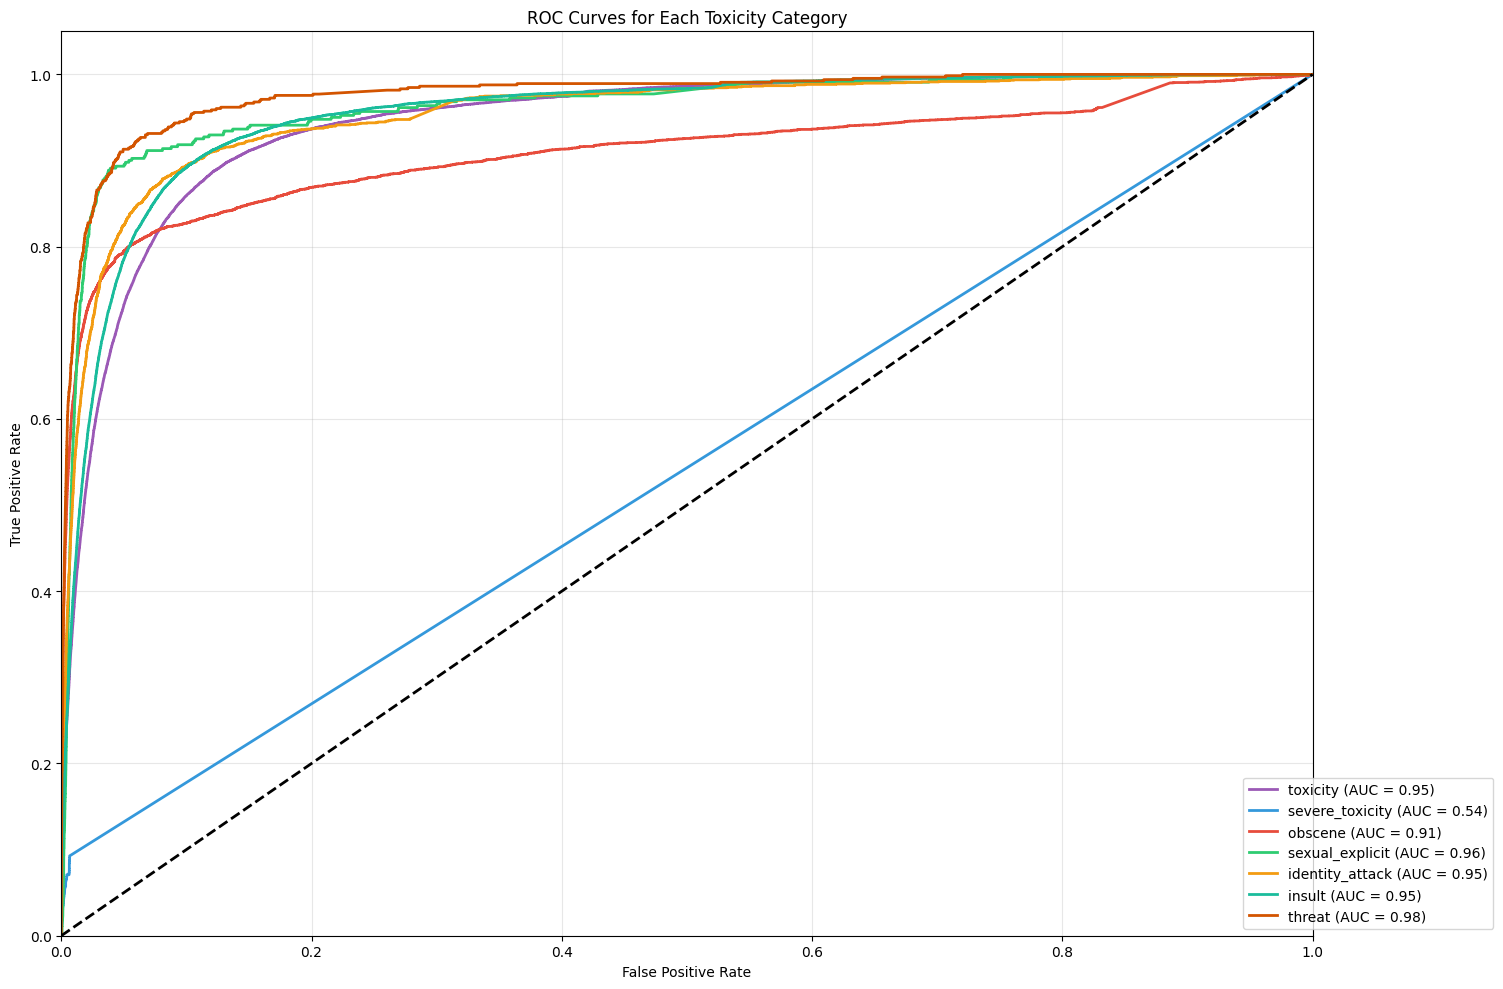

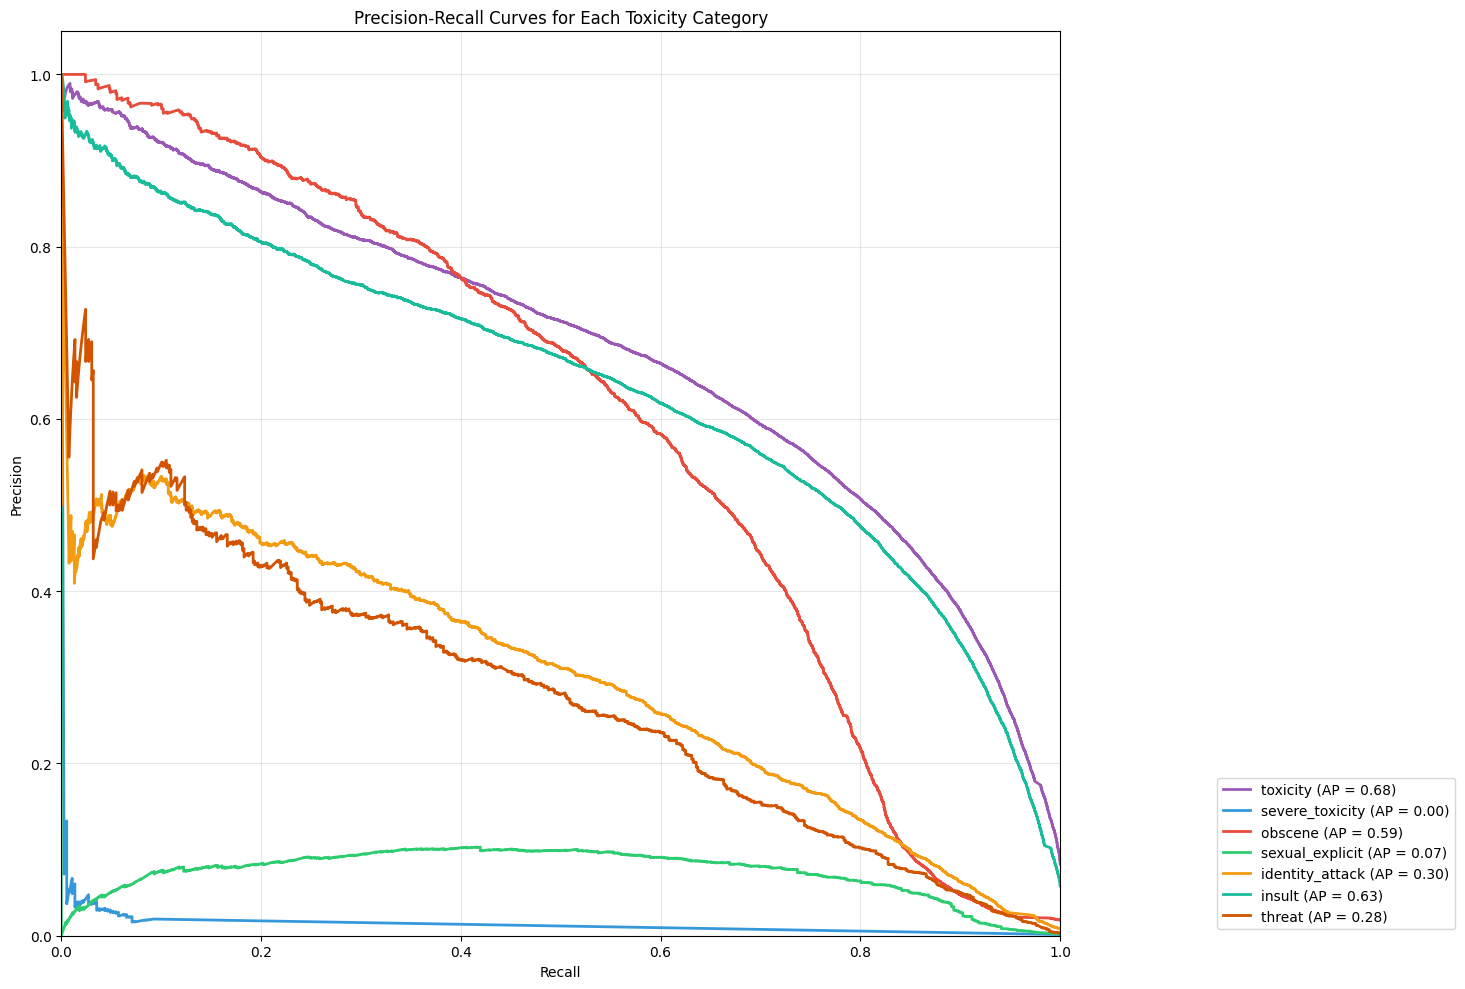

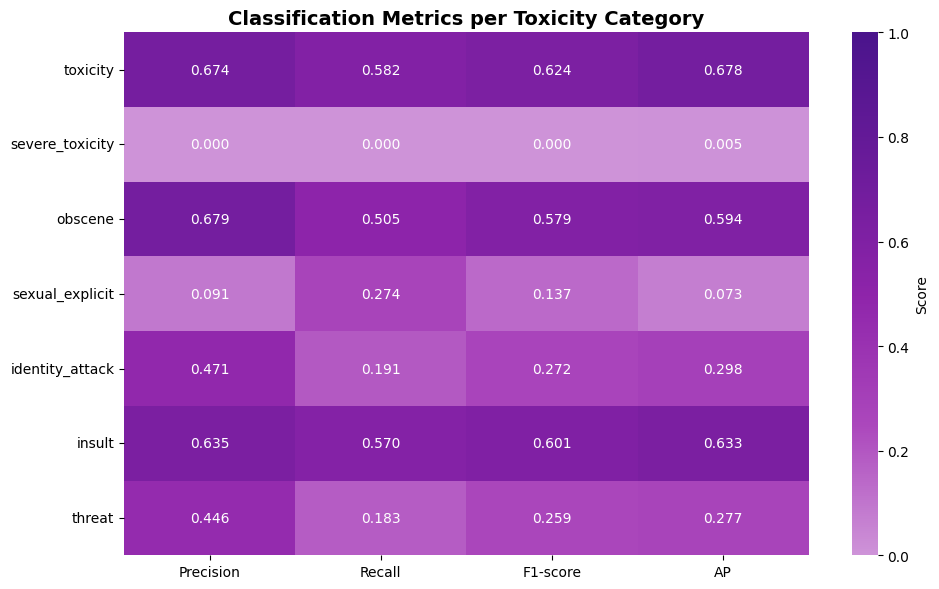

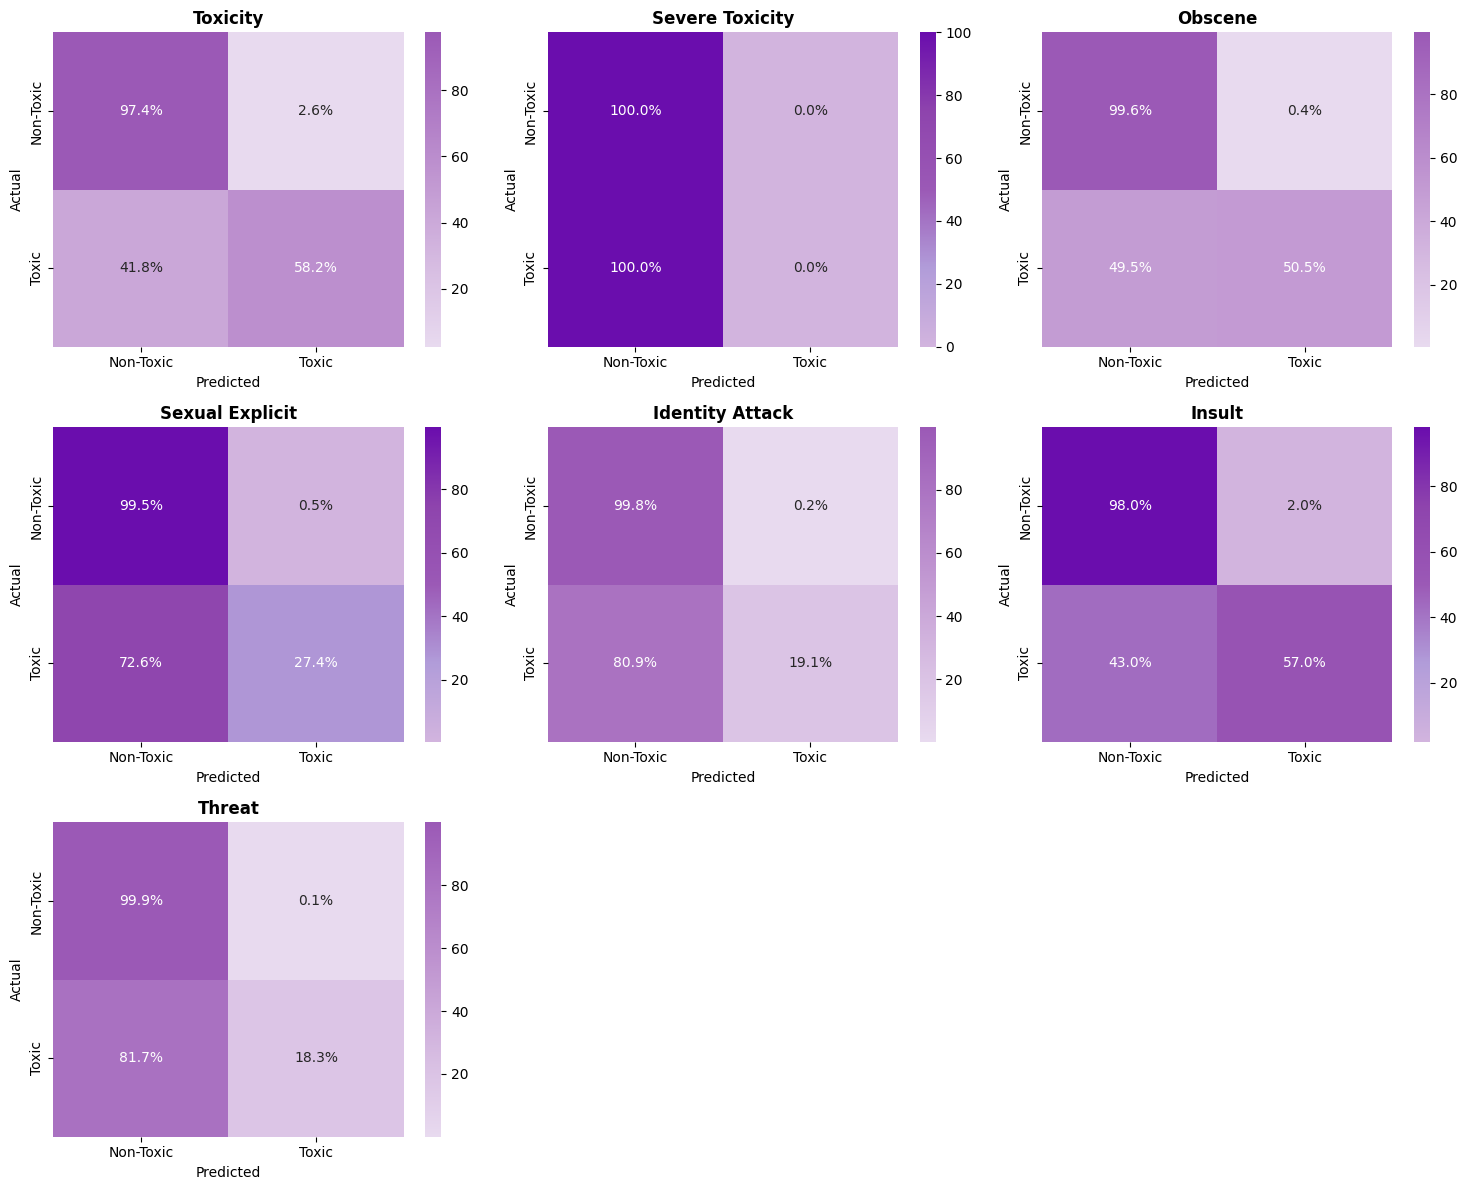

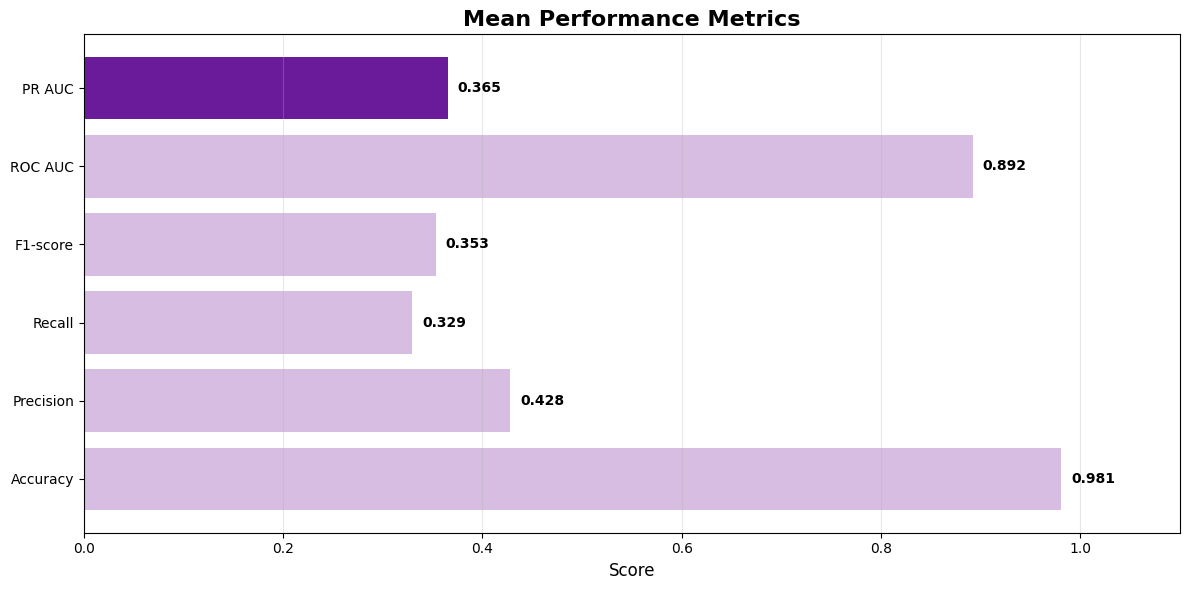


Detailed Classification Report:
--------------------------------------------------

Category: toxicity
Precision: 0.674
Recall: 0.582
F1-score: 0.624
Accuracy: 0.942
ROC AUC: 0.945
Average Precision: 0.678

Category: severe_toxicity
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Accuracy: 0.999
ROC AUC: 0.543
Average Precision: 0.005

Category: obscene
Precision: 0.679
Recall: 0.505
F1-score: 0.579
Accuracy: 0.986
ROC AUC: 0.910
Average Precision: 0.594

Category: sexual_explicit
Precision: 0.091
Recall: 0.274
F1-score: 0.137
Accuracy: 0.994
ROC AUC: 0.963
Average Precision: 0.073

Category: identity_attack
Precision: 0.471
Recall: 0.191
F1-score: 0.272
Accuracy: 0.992
ROC AUC: 0.954
Average Precision: 0.298

Category: insult
Precision: 0.635
Recall: 0.570
F1-score: 0.601
Accuracy: 0.956
ROC AUC: 0.953
Average Precision: 0.633

Category: threat
Precision: 0.446
Recall: 0.183
F1-score: 0.259
Accuracy: 0.997
ROC AUC: 0.977
Average Precision: 0.277

Mean Metrics Across All Toxicity Categ

In [61]:
# Prepare the test set
y_test_binary = (y_test >= 0.5).astype(int)  # Convert to binary
test_set = (X_test_tfidf, y_test_binary)
y_train_binary = (y_train >= 0.5).astype(int)

base_classifier = LogisticRegression(solver= 'liblinear', penalty='l1', max_iter= 1000, class_weight= None, C= 1.0)
best_model = OneVsRestClassifier(base_classifier)
best_model.fit(X_train_tfidf, y_train_binary)

# Evaluate the model
print("Evaluating the model...")
evaluation_results_raw_data = evaluate_model(model=best_model, test_set=test_set)

# Baseline with Undersampled Dataset

> Baseline Model: Logistic Regression with Undersampling and Data from the Wikipedia dataset -> Merged Dataset + Undersampling

In [ ]:
toxic_categories = ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat']
X_train, y_train = load_and_preprocess_data("../../data/merged_data/undersampled_dataset.csv", toxic_categories)
X_test, y_test = load_and_preprocess_data("../../data/merged_data/test_merged.csv", toxic_categories)

Data loaded with shape: (457983, 34)
Target categories: ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat']


/var/folders/xy/xqxsj6796gl11wpqz6hp11sr0000gn/T/ipykernel_5360/4095953715.py:18: DtypeWarning: Columns (3,4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('../../data/merged_data/test_merged.csv')


> Feature Extraction with TF IDF

In [55]:
# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(
    max_features=20000,  
    min_df=3,            # Minimum document frequency
    max_df=0.9,          # Maximum document frequency
    ngram_range=(1, 3),  # Include unigrams, bigrams, and trigrams
    stop_words='english'
)


# Transform the text data to TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Training set shape: {X_train_tfidf.shape}")
print(f"Testing set shape: {X_test_tfidf.shape}")
print(f"Target shape: {y_train.shape}")


Training set shape: (457983, 20000)
Testing set shape: (258619, 20000)
Target shape: (457983, 7)


Evaluating the model...


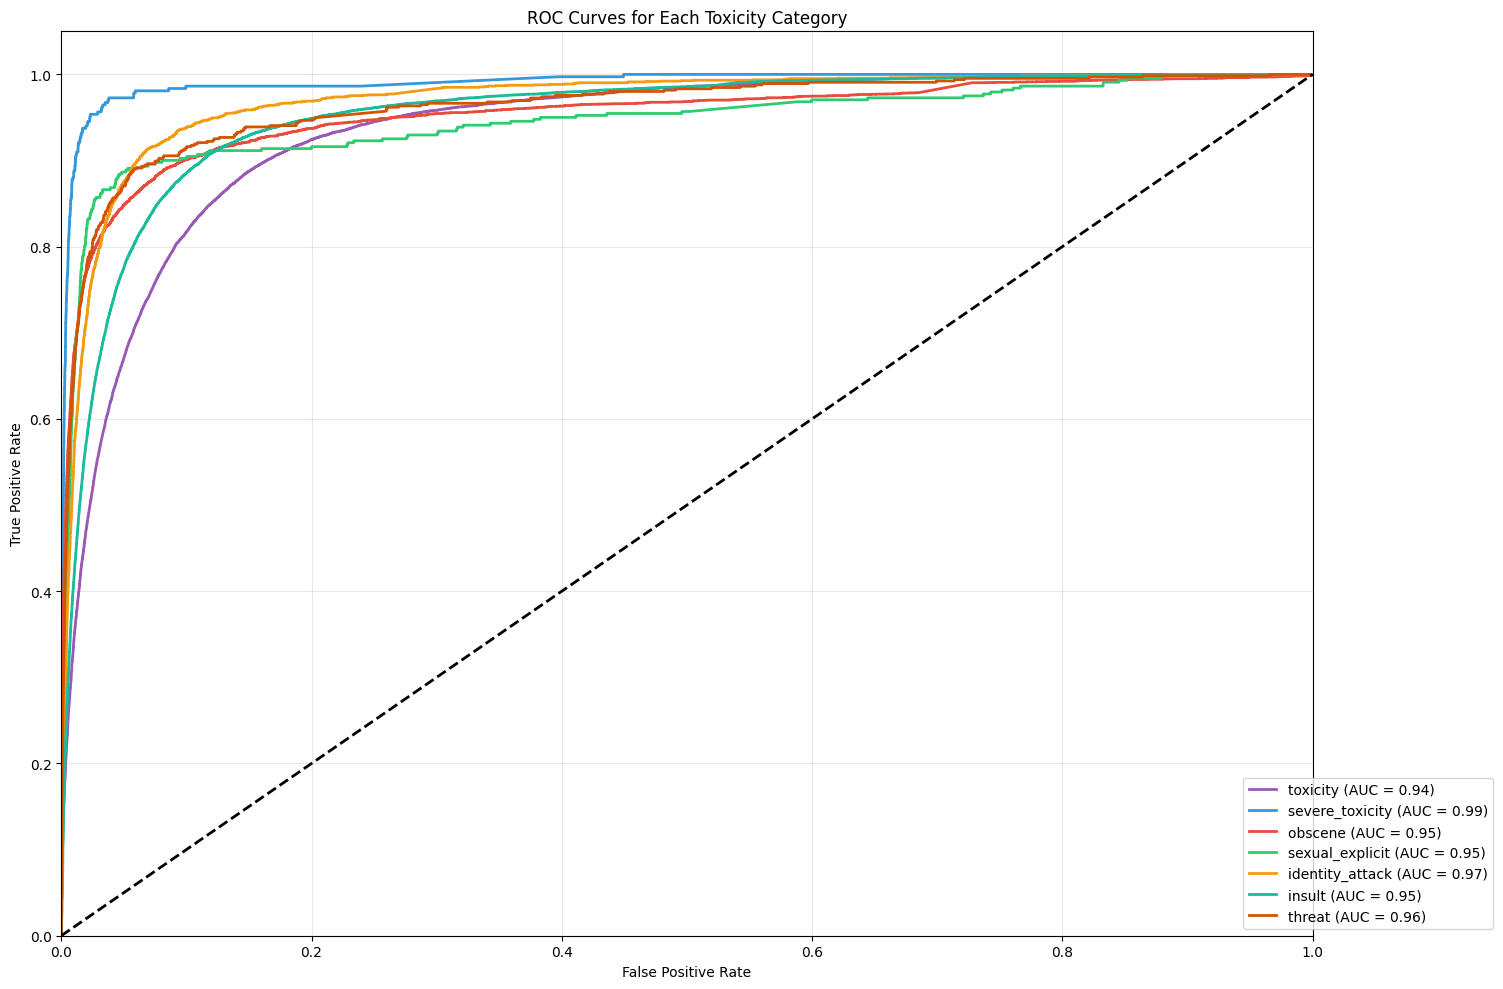

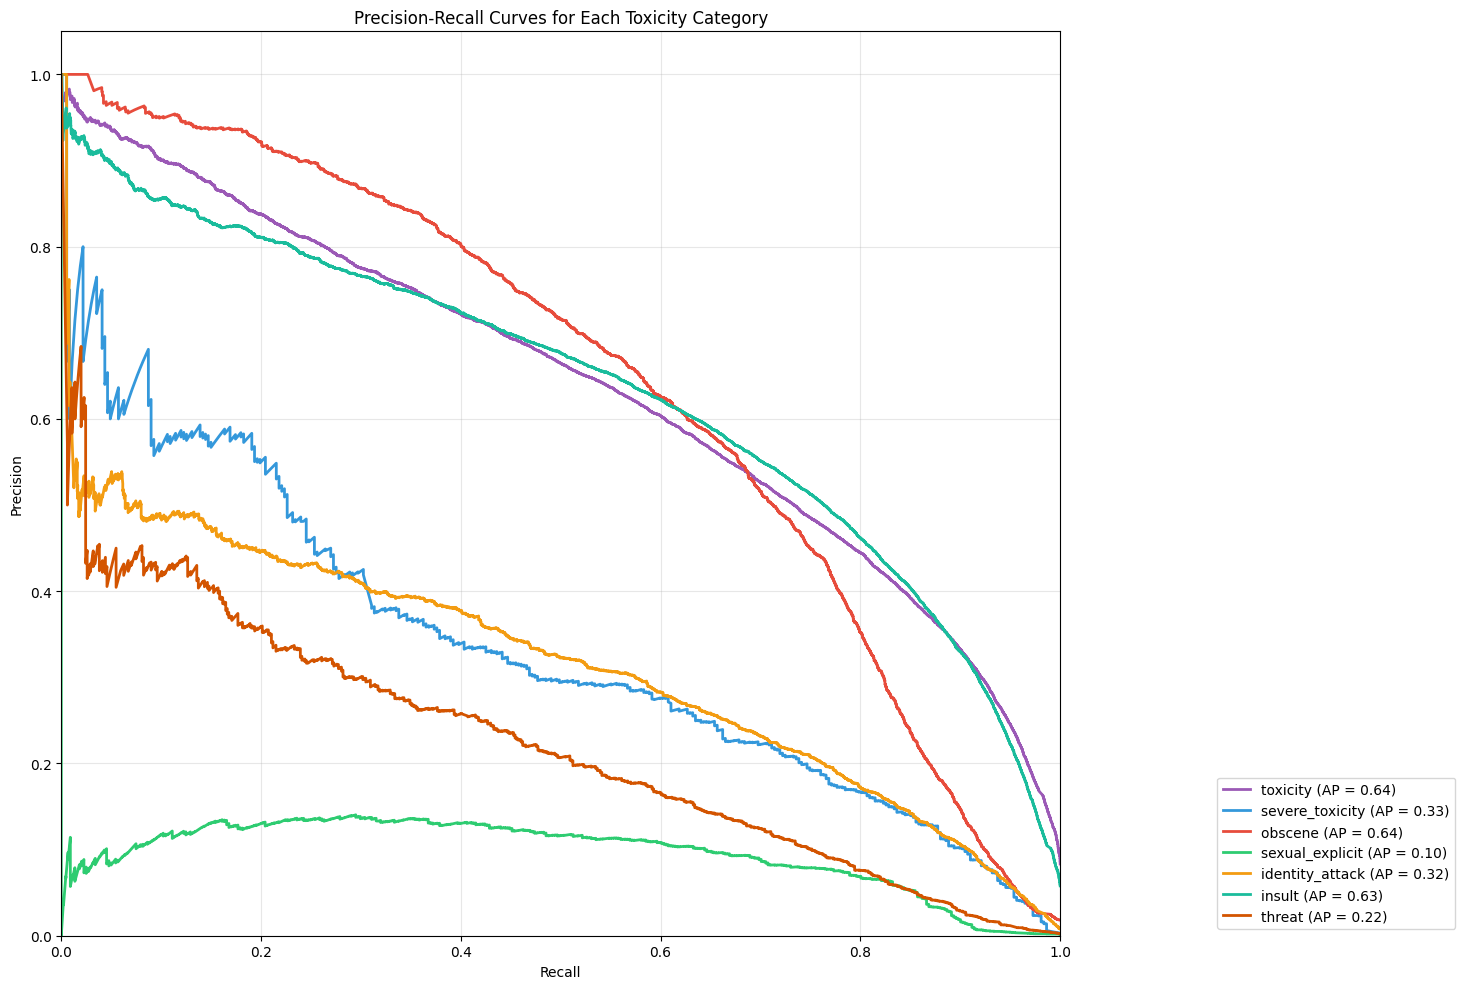

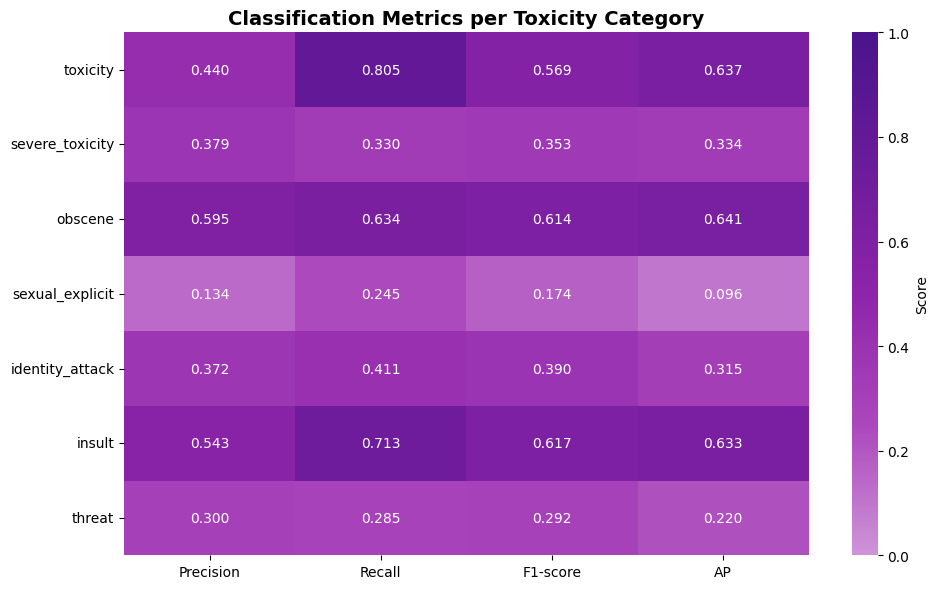

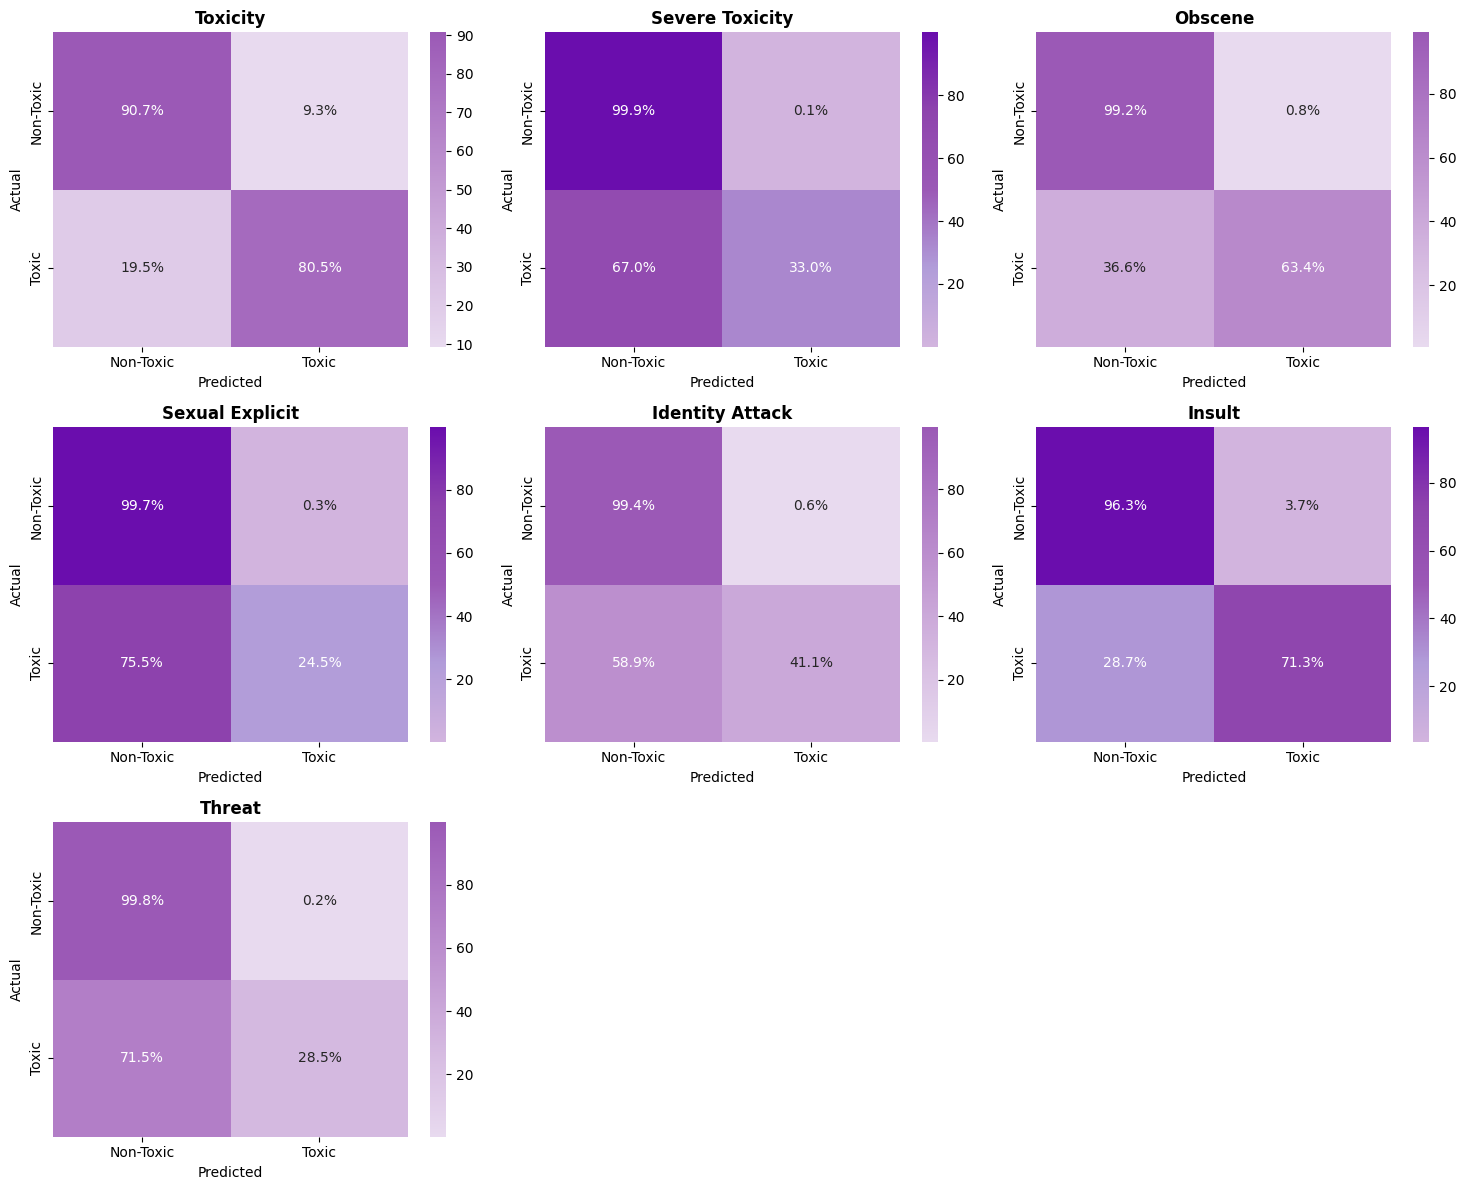

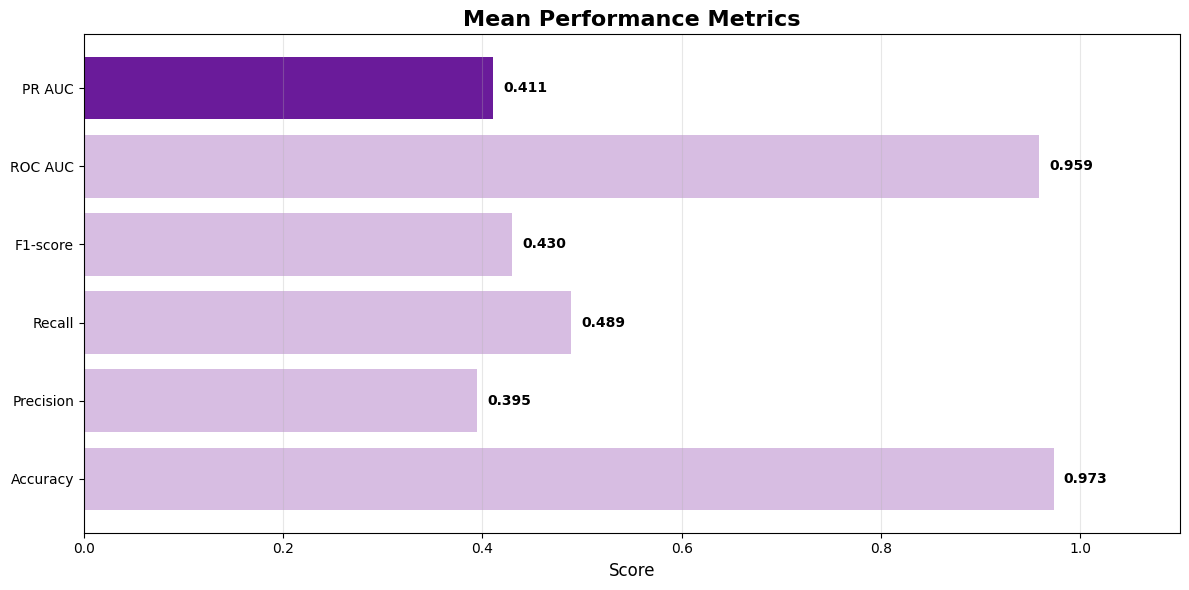


Detailed Classification Report:
--------------------------------------------------

Category: toxicity
Precision: 0.440
Recall: 0.805
F1-score: 0.569
Accuracy: 0.898
ROC AUC: 0.937
Average Precision: 0.637

Category: severe_toxicity
Precision: 0.379
Recall: 0.330
F1-score: 0.353
Accuracy: 0.998
ROC AUC: 0.991
Average Precision: 0.334

Category: obscene
Precision: 0.595
Recall: 0.634
F1-score: 0.614
Accuracy: 0.985
ROC AUC: 0.953
Average Precision: 0.641

Category: sexual_explicit
Precision: 0.134
Recall: 0.245
F1-score: 0.174
Accuracy: 0.996
ROC AUC: 0.946
Average Precision: 0.096

Category: identity_attack
Precision: 0.372
Recall: 0.411
F1-score: 0.390
Accuracy: 0.990
ROC AUC: 0.970
Average Precision: 0.315

Category: insult
Precision: 0.543
Recall: 0.713
F1-score: 0.617
Accuracy: 0.949
ROC AUC: 0.953
Average Precision: 0.633

Category: threat
Precision: 0.300
Recall: 0.285
F1-score: 0.292
Accuracy: 0.996
ROC AUC: 0.963
Average Precision: 0.220

Mean Metrics Across All Toxicity Categ

In [56]:
# Prepare the test set
y_test_binary = (y_test >= 0.5).astype(int)  # Convert to binary
test_set = (X_test_tfidf, y_test_binary)

# Convert training labels to binary
y_train_binary = (y_train >= 0.5).astype(int)  # Convert to binary

# Create the model with best parameters
model = LogisticRegression(
    C=1.0,
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    class_weight=None,
    random_state=42
)

# Wrap in OneVsRestClassifier for multi-label classification
multilabel_classifier = OneVsRestClassifier(model)

# Fit the model with binary labels
multilabel_classifier.fit(X_train_tfidf, y_train_binary)

# Evaluate the model
print("Evaluating the model...")
evaluation_results_undersampling = evaluate_model(model=multilabel_classifier, test_set=test_set)


> Comparing with the Baseline using Raw Data

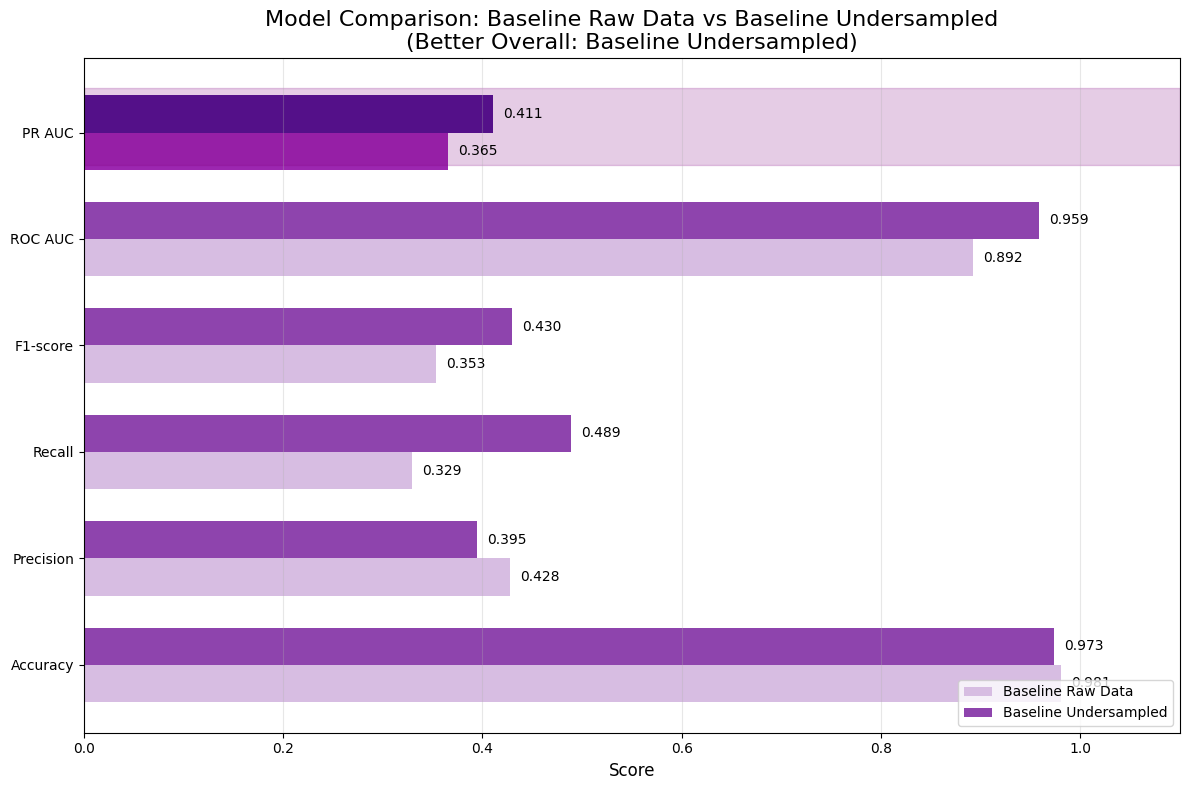


Numeric Comparison (Baseline Raw Data vs Baseline Undersampled):
--------------------------------------------------

Overall Metrics:
Accuracy    : 0.981 vs 0.973 (Diff: 0.008, Better: Baseline Raw Data)
Precision   : 0.428 vs 0.395 (Diff: 0.033, Better: Baseline Raw Data)
Recall      : 0.329 vs 0.489 (Diff: 0.160, Better: Baseline Undersampled)
F1-score    : 0.353 vs 0.430 (Diff: 0.077, Better: Baseline Undersampled)
ROC AUC     : 0.892 vs 0.959 (Diff: 0.067, Better: Baseline Undersampled)
PR AUC      : 0.365 vs 0.411 (Diff: 0.045, Better: Baseline Undersampled)

Per-Class Metrics:

toxicity:
precision   : 0.674 vs 0.440 (Diff: 0.234, Better: Baseline Raw Data)
recall      : 0.582 vs 0.805 (Diff: 0.223, Better: Baseline Undersampled)
f1_score    : 0.624 vs 0.569 (Diff: 0.055, Better: Baseline Raw Data)
accuracy    : 0.942 vs 0.898 (Diff: 0.043, Better: Baseline Raw Data)
roc_auc     : 0.945 vs 0.937 (Diff: 0.008, Better: Baseline Raw Data)
average_precision: 0.678 vs 0.637 (Diff: 0.0

In [62]:
compare_models(
    evaluation_results_raw_data, 
    evaluation_results_undersampling, 
    model1_name="Baseline Raw Data", 
    model2_name="Baseline Undersampled"
)

# Baseline with Undersampling and Combining Categories

In [ ]:
toxic_categories = ['toxicity', 'identity_attack', 'insult' ]
X_train, y_train = load_and_preprocess_data("../../data/merged_data/undersampled_dataset.csv", toxic_categories)
X_test, y_test = load_and_preprocess_data("../../data/merged_data/test_merged.csv", toxic_categories)

Data loaded with shape: (457983, 34)
Target categories: ['toxicity', 'identity_attack', 'insult']


/var/folders/xy/xqxsj6796gl11wpqz6hp11sr0000gn/T/ipykernel_5360/1115646715.py:17: DtypeWarning: Columns (3,4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv("../../data/merged_data/test_merged.csv")


Training set shape: (457983, 20000)
Testing set shape: (258619, 20000)
Target shape: (457983, 3)


In [ ]:
# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(
    max_features=20000,  
    min_df=3,            # Minimum document frequency
    max_df=0.9,          # Maximum document frequency
    ngram_range=(1, 3),  # Include unigrams, bigrams, and trigrams
    stop_words='english'
)


# Transform the text data to TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Training set shape: {X_train_tfidf.shape}")
print(f"Testing set shape: {X_test_tfidf.shape}")
print(f"Target shape: {y_train.shape}")

Evaluating the model...


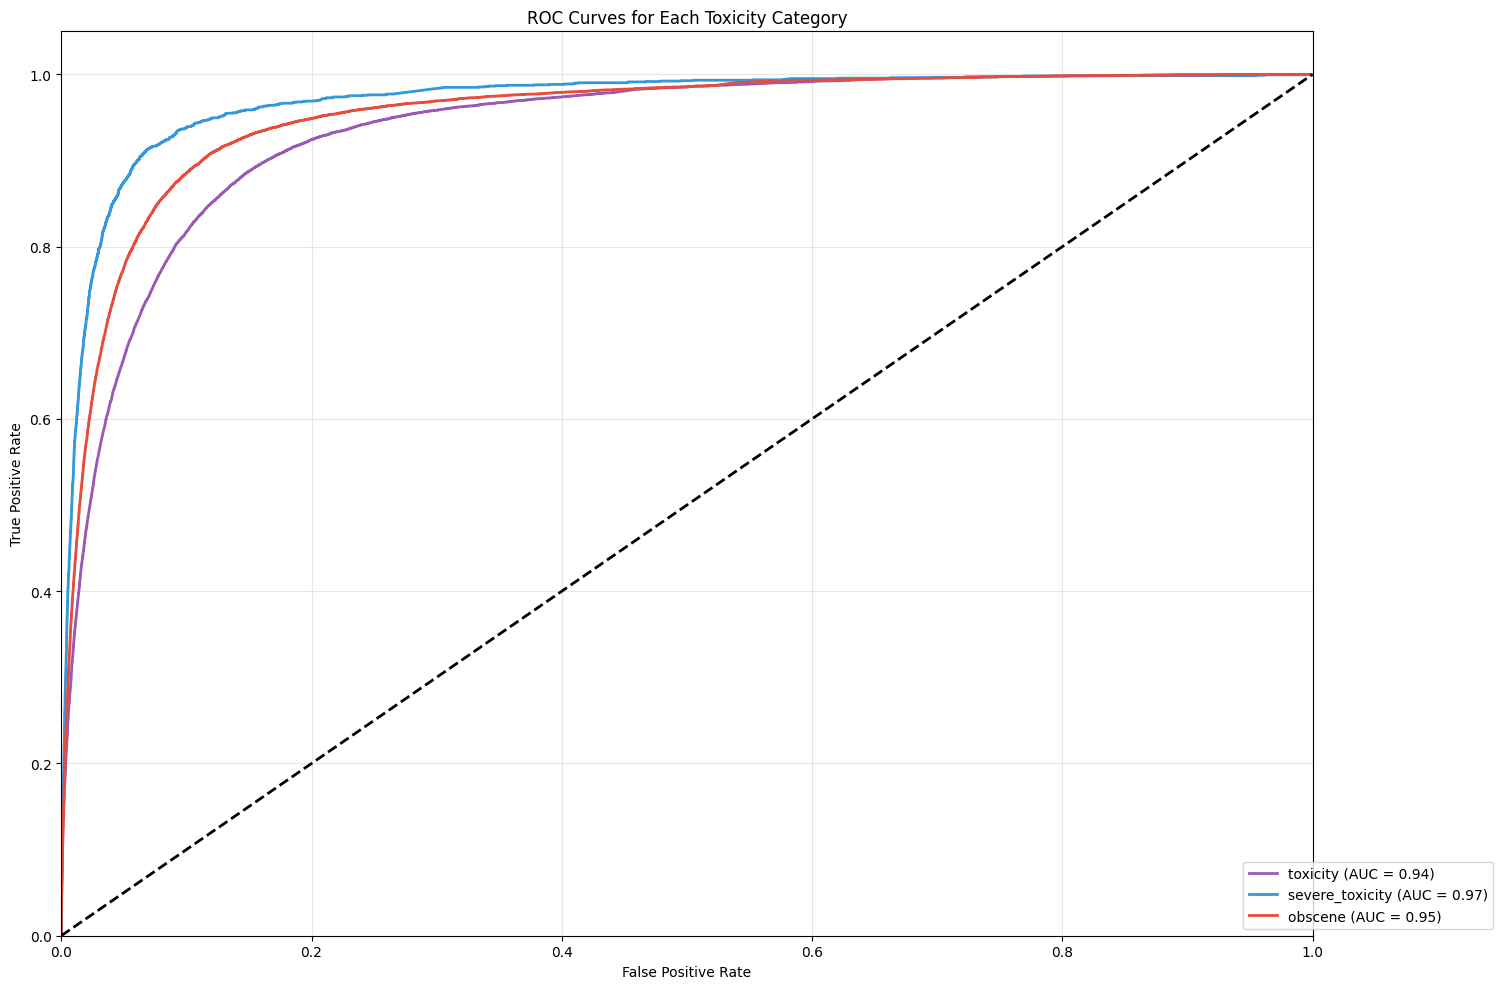

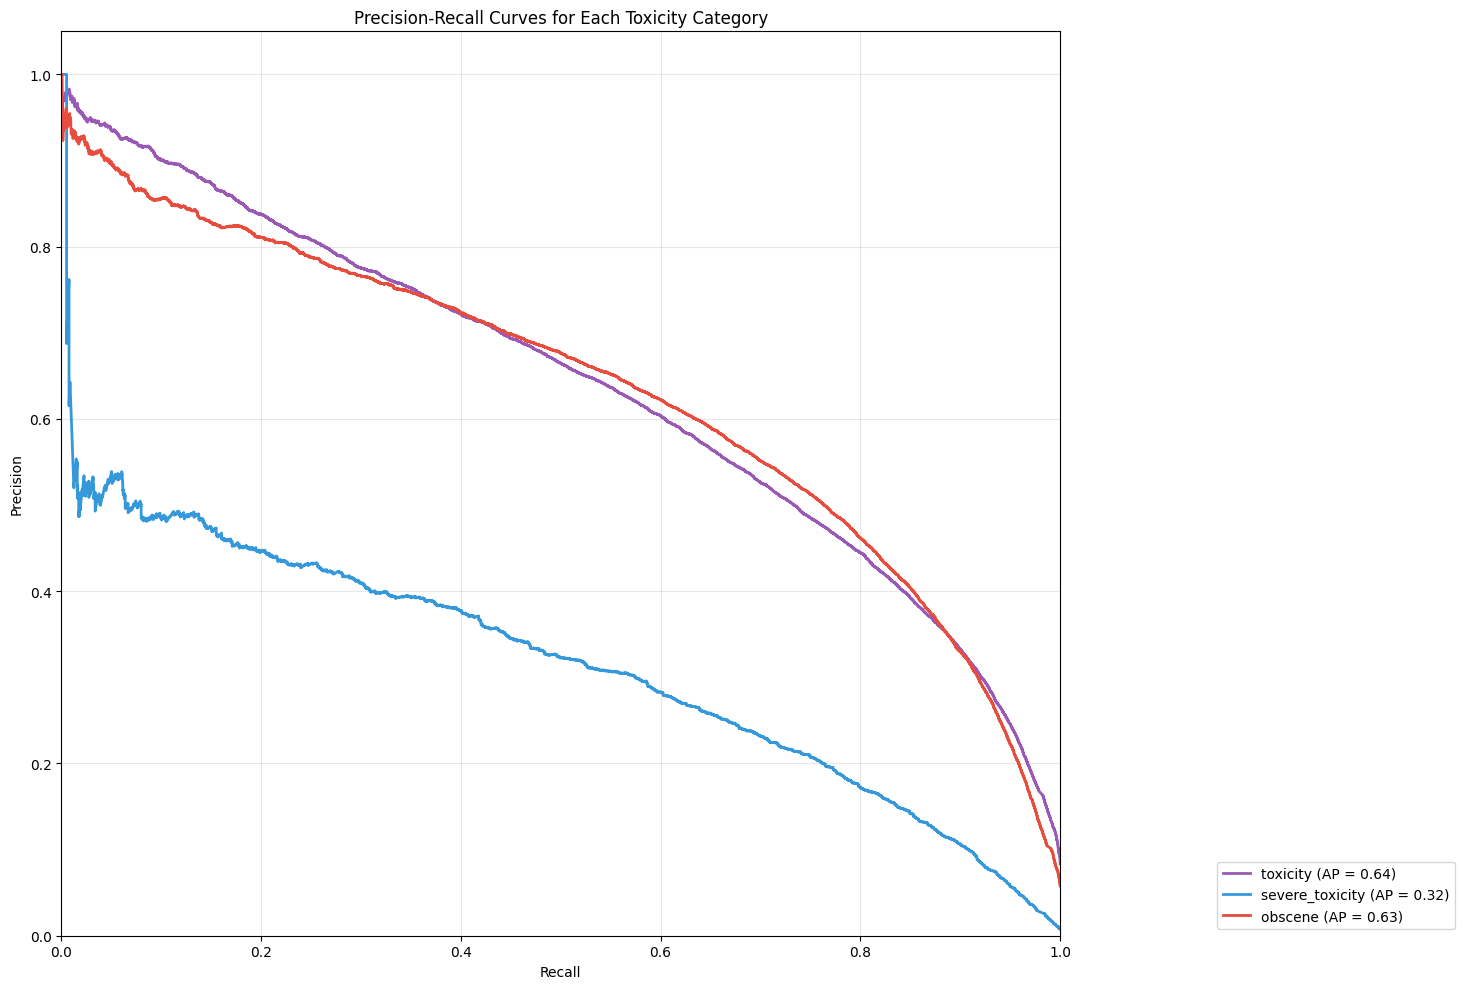

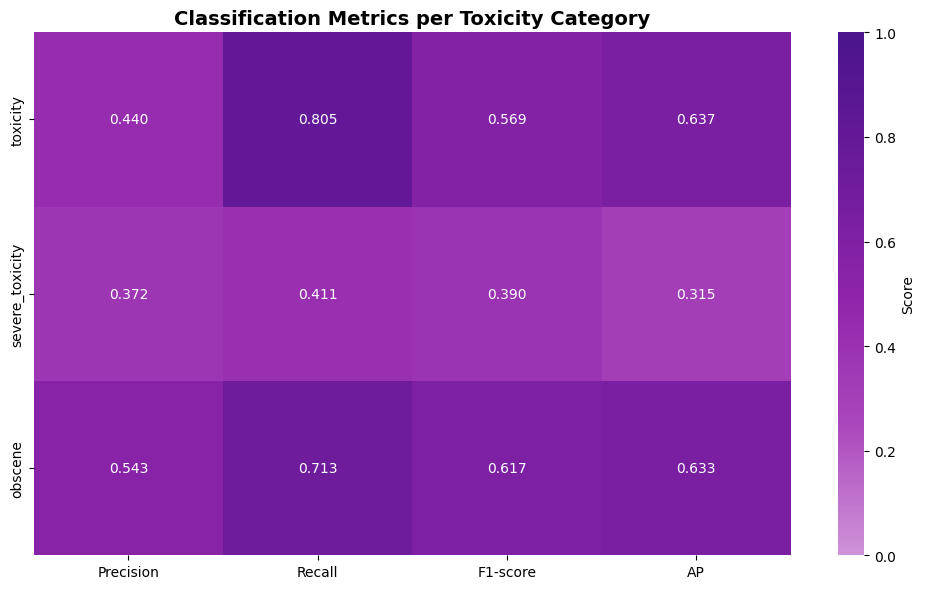

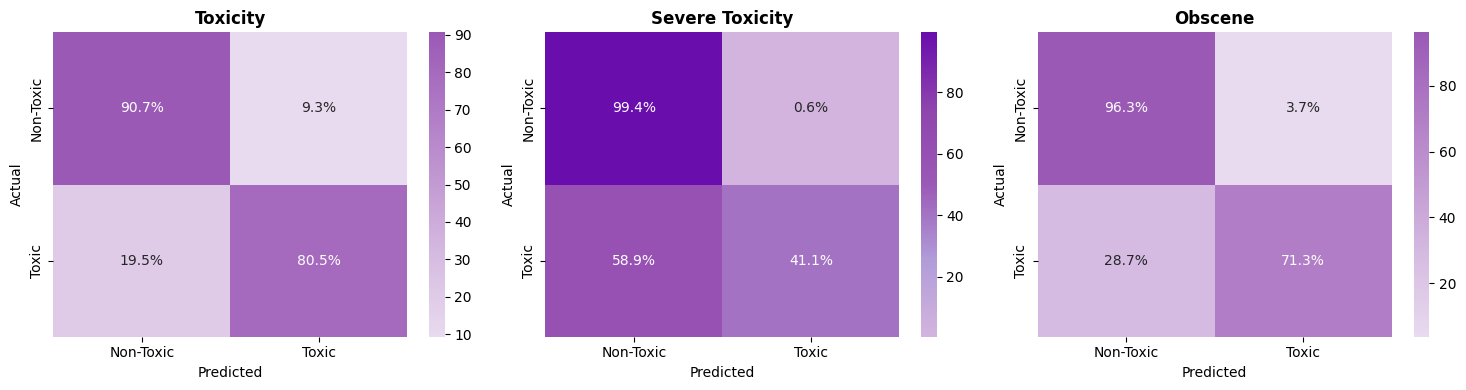

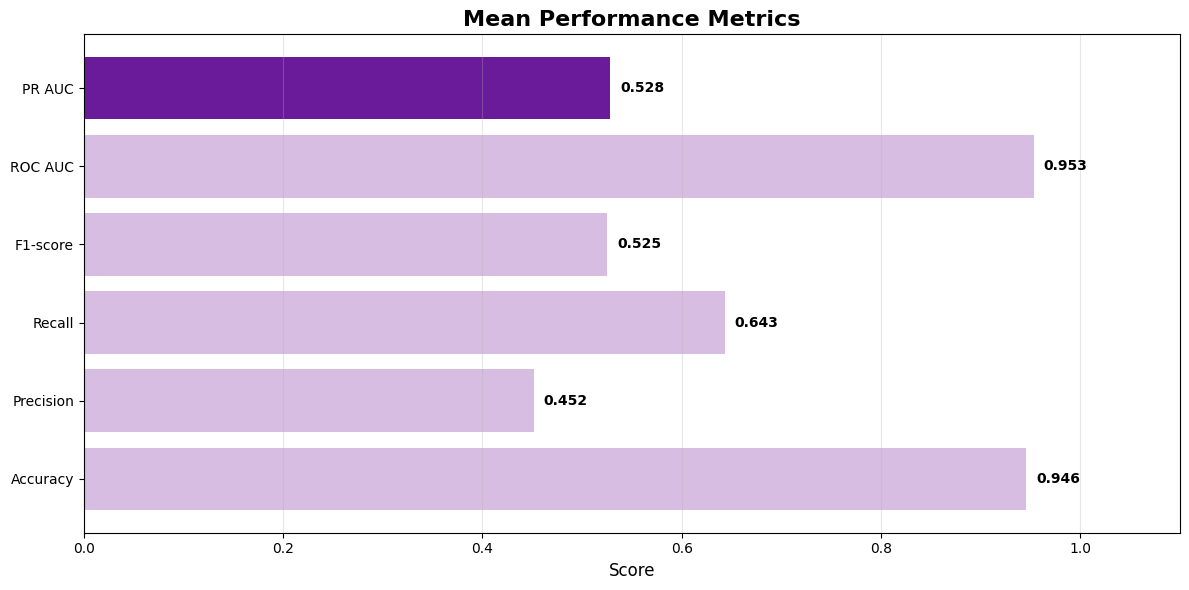


Detailed Classification Report:
--------------------------------------------------

Category: toxicity
Precision: 0.440
Recall: 0.805
F1-score: 0.569
Accuracy: 0.898
ROC AUC: 0.937
Average Precision: 0.637

Category: severe_toxicity
Precision: 0.372
Recall: 0.411
F1-score: 0.390
Accuracy: 0.990
ROC AUC: 0.970
Average Precision: 0.315

Category: obscene
Precision: 0.543
Recall: 0.713
F1-score: 0.617
Accuracy: 0.949
ROC AUC: 0.953
Average Precision: 0.633

Mean Metrics Across All Toxicity Categories:
--------------------------------------------------
mean_roc_auc: 0.953
mean_average_precision: 0.528
mean_precision: 0.452
mean_recall: 0.643
mean_f1_score: 0.525
mean_accuracy: 0.946
macro_avg:
  precision: 0.452
  recall: 0.643
  f1_score: 0.525
weighted_avg:
  precision: 0.476
  recall: 0.748
  f1_score: 0.578
total_support:
  negative: 737284.000
  positive: 38573.000


In [50]:
# Prepare the test set
y_test_binary = (y_test >= 0.5).astype(int)  # Convert to binary
test_set = (X_test_tfidf, y_test_binary)

# Convert training labels to binary
y_train_binary = (y_train >= 0.5).astype(int)  # Convert to binary

# Create the model with best parameters
model = LogisticRegression(
    C=1.0,
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    class_weight=None,
    random_state=42
)

# Wrap in OneVsRestClassifier for multi-label classification
multilabel_classifier = OneVsRestClassifier(model)

# Fit the model with binary labels
multilabel_classifier.fit(X_train_tfidf, y_train_binary)

# Evaluate the model
print("Evaluating the model...")
evaluation_results_undersampling = evaluate_model(model=multilabel_classifier, test_set=test_set)


# Baseline with Backtranslated Dataset

In [ ]:
toxic_categories = ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat']
X_train, y_train = load_and_preprocess_data("../../data/merged_data/backtranslated_dataset.csv", toxic_categories)
X_test, y_test = load_and_preprocess_data("../../data/merged_data/test_merged.csv", toxic_categories)

In [ ]:
# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(
    max_features=40000,  
    min_df=3,            # Minimum document frequency
    max_df=0.9,          # Maximum document frequency
    ngram_range=(1, 4),  # Include unigrams, bigrams, and trigrams
    stop_words='english'
)

# Transform the text data to TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Training set shape: {X_train_tfidf.shape}")
print(f"Testing set shape: {X_test_tfidf.shape}")
print(f"Target shape: {y_train.shape}")

Data loaded with shape: (535143, 33)
Target categories: ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat']


/var/folders/xy/xqxsj6796gl11wpqz6hp11sr0000gn/T/ipykernel_5360/1580093286.py:17: DtypeWarning: Columns (3,4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv("../../data/merged_data/test_merged.csv")


Training set shape: (535143, 40000)
Testing set shape: (258619, 40000)
Target shape: (535143, 7)


Evaluating the model...


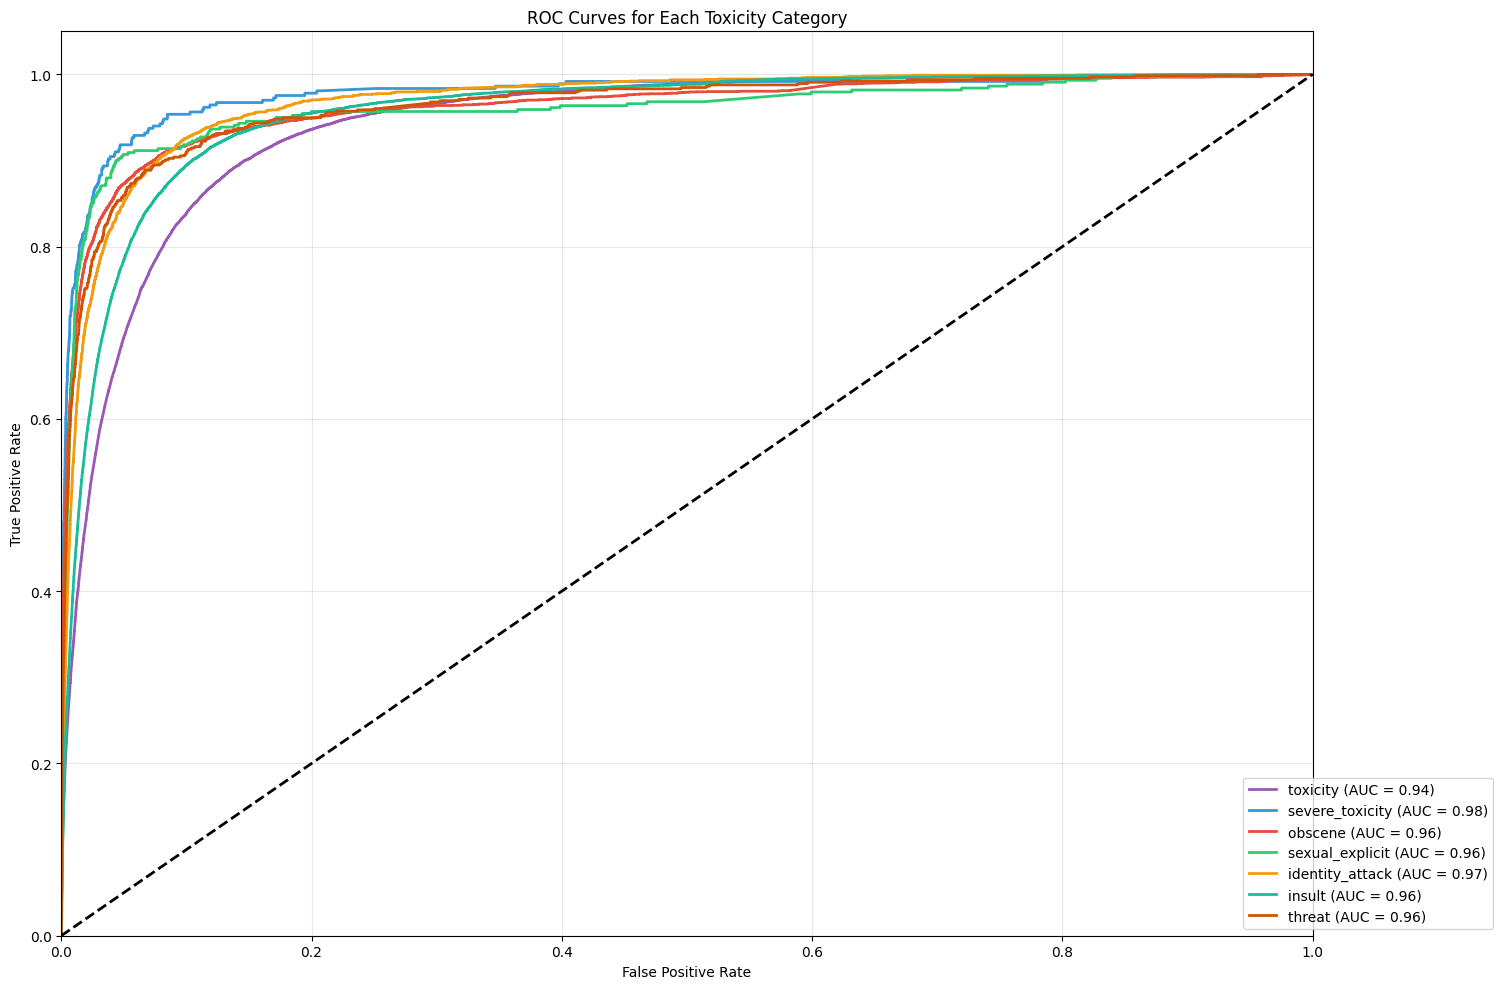

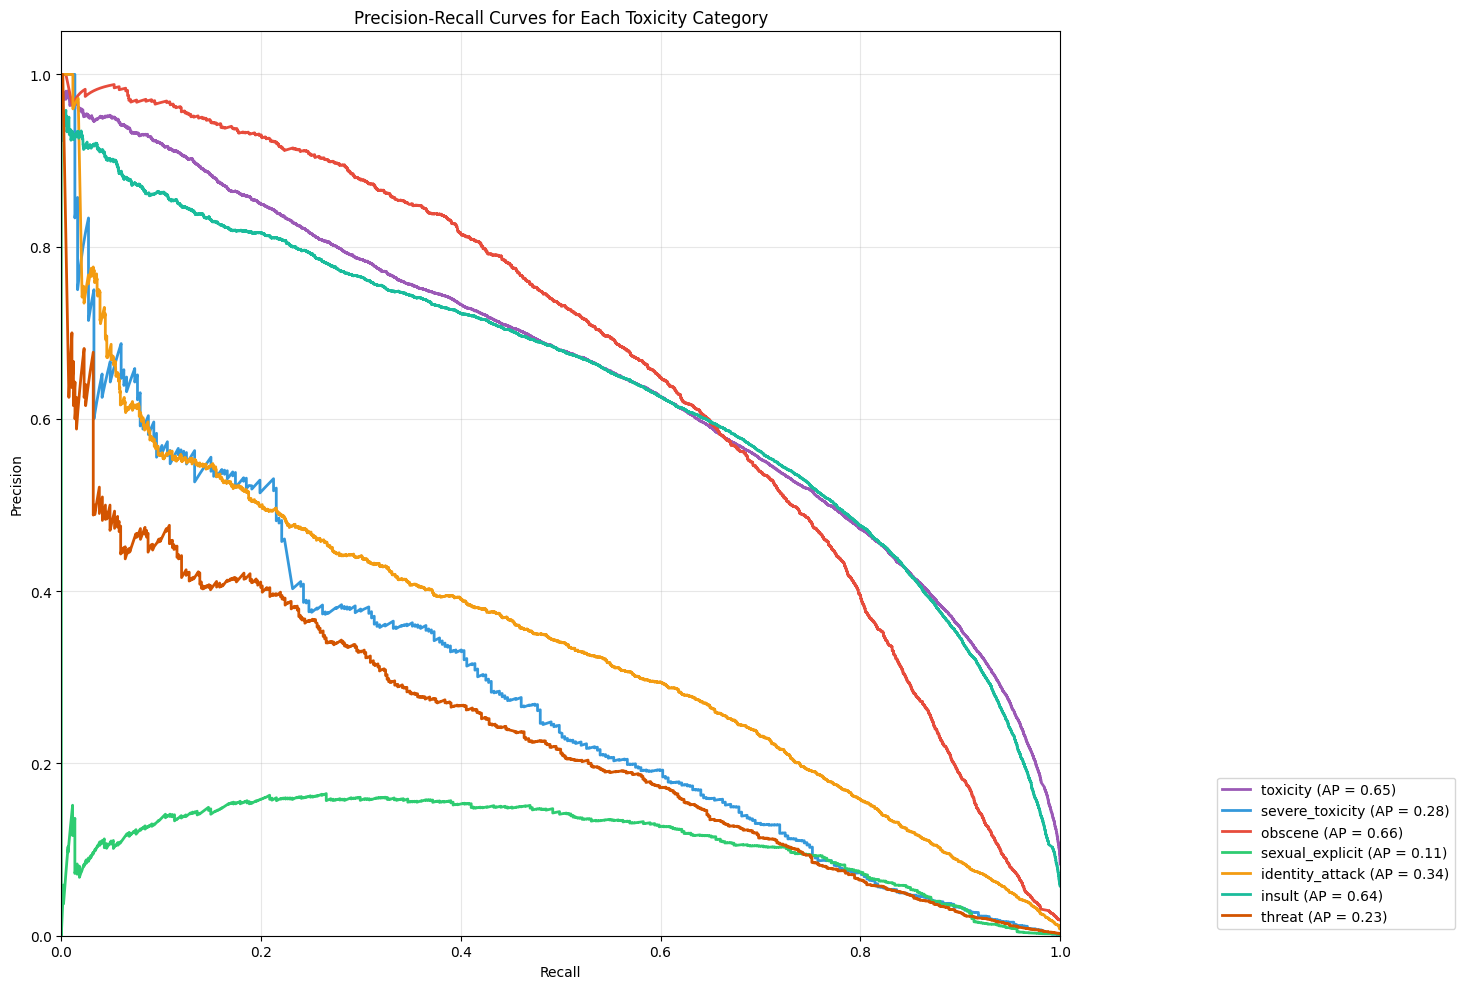

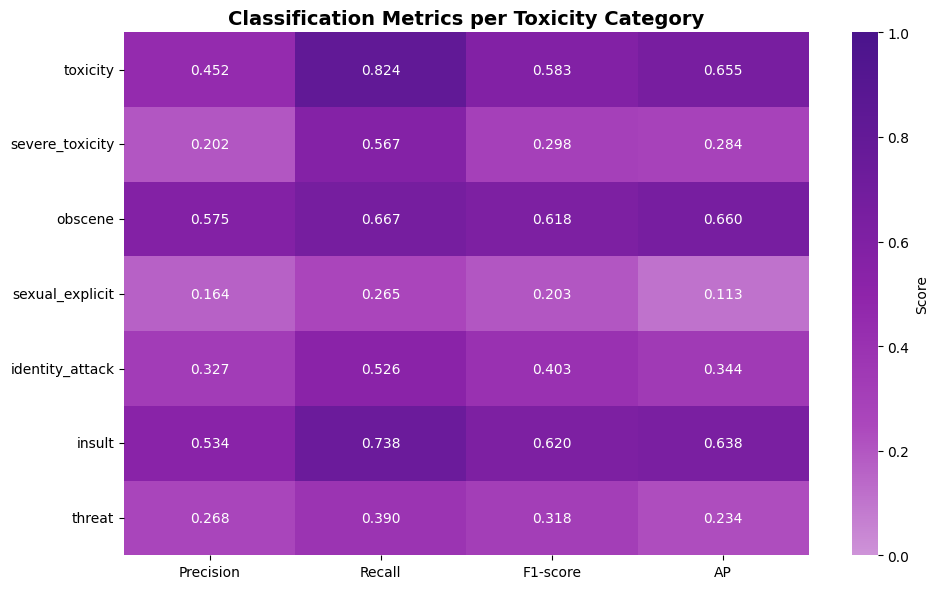

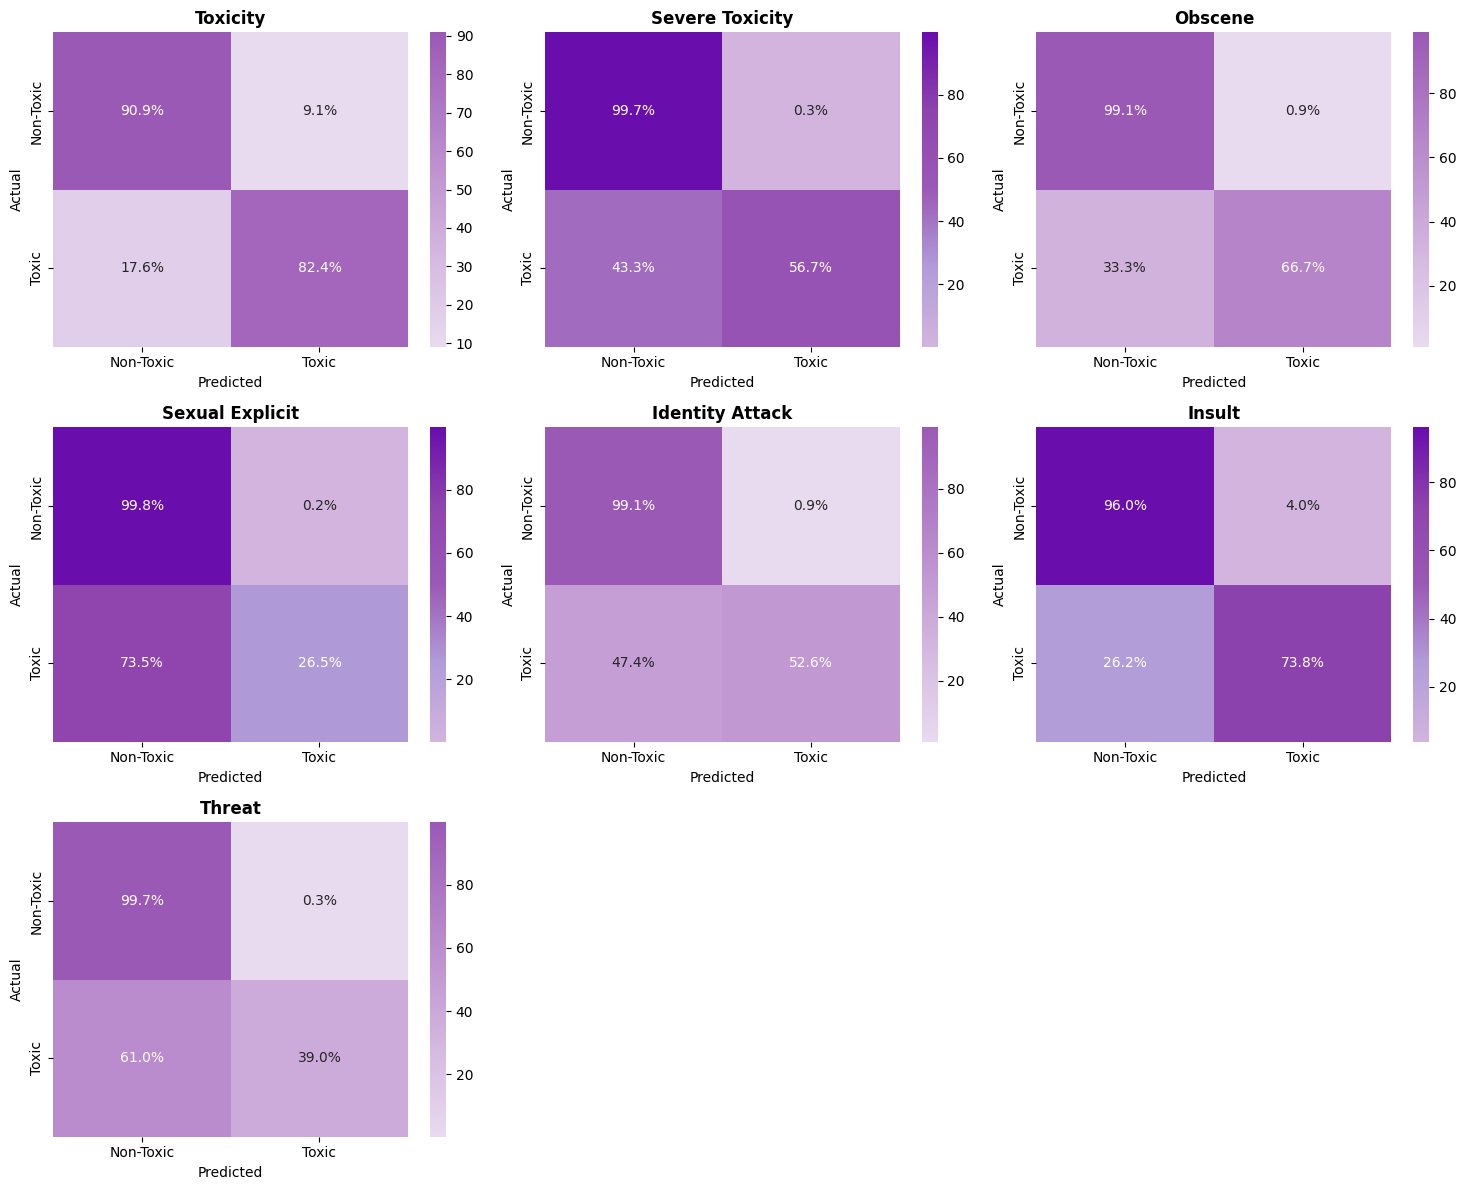

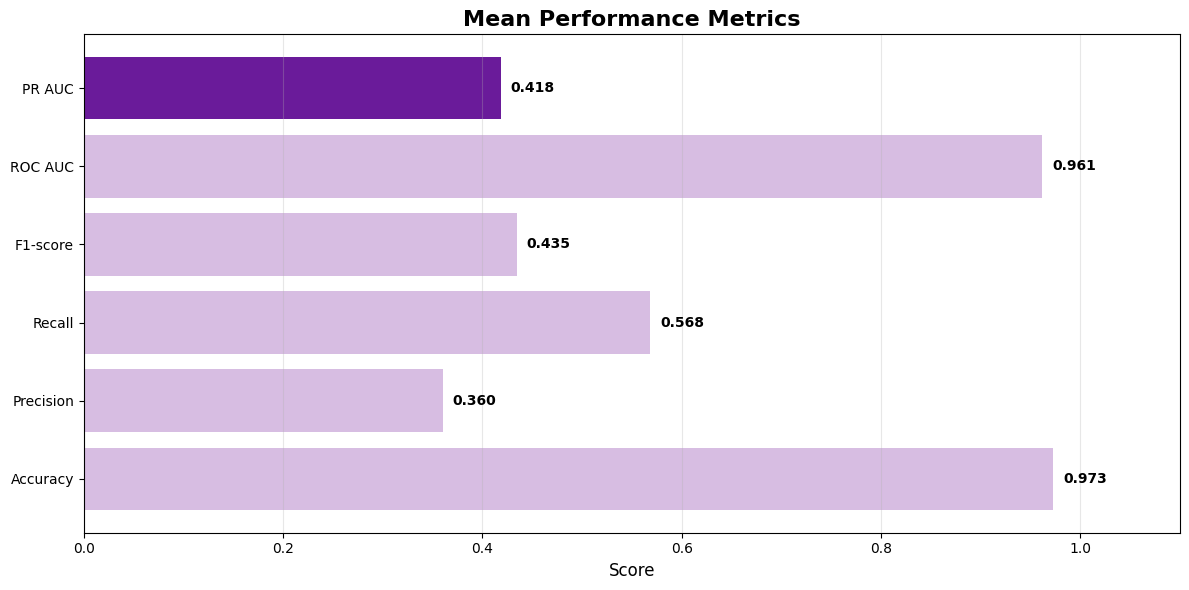


Detailed Classification Report:
--------------------------------------------------

Category: toxicity
Precision: 0.452
Recall: 0.824
F1-score: 0.583
Accuracy: 0.902
ROC AUC: 0.943
Average Precision: 0.655

Category: severe_toxicity
Precision: 0.202
Recall: 0.567
F1-score: 0.298
Accuracy: 0.996
ROC AUC: 0.977
Average Precision: 0.284

Category: obscene
Precision: 0.575
Recall: 0.667
F1-score: 0.618
Accuracy: 0.985
ROC AUC: 0.962
Average Precision: 0.660

Category: sexual_explicit
Precision: 0.164
Recall: 0.265
F1-score: 0.203
Accuracy: 0.996
ROC AUC: 0.960
Average Precision: 0.113

Category: identity_attack
Precision: 0.327
Recall: 0.526
F1-score: 0.403
Accuracy: 0.988
ROC AUC: 0.968
Average Precision: 0.344

Category: insult
Precision: 0.534
Recall: 0.738
F1-score: 0.620
Accuracy: 0.948
ROC AUC: 0.956
Average Precision: 0.638

Category: threat
Precision: 0.268
Recall: 0.390
F1-score: 0.318
Accuracy: 0.996
ROC AUC: 0.963
Average Precision: 0.234

Mean Metrics Across All Toxicity Categ

In [ ]:
# Prepare the test set
y_test_binary = (y_test >= 0.5).astype(int)  # Convert to binary
test_set = (X_test_tfidf, y_test_binary)

# Convert training labels to binary
y_train_binary = (y_train >= 0.5).astype(int)  # Convert to binary

# Create the model with best parameters
model = LogisticRegression(
    C=1.0,
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    class_weight=None,
    random_state=42
)

# Wrap in OneVsRestClassifier for multi-label classification
multilabel_classifier = OneVsRestClassifier(model)

# Fit the model with binary labels
multilabel_classifier.fit(X_train_tfidf, y_train_binary)

# Evaluate the model
print("Evaluating the model...")
evaluation_results_undersampling = evaluate_model(model=multilabel_classifier, test_set=test_set)

## Threshold Analysis with the Model Trained with the Backtranslated Dataset

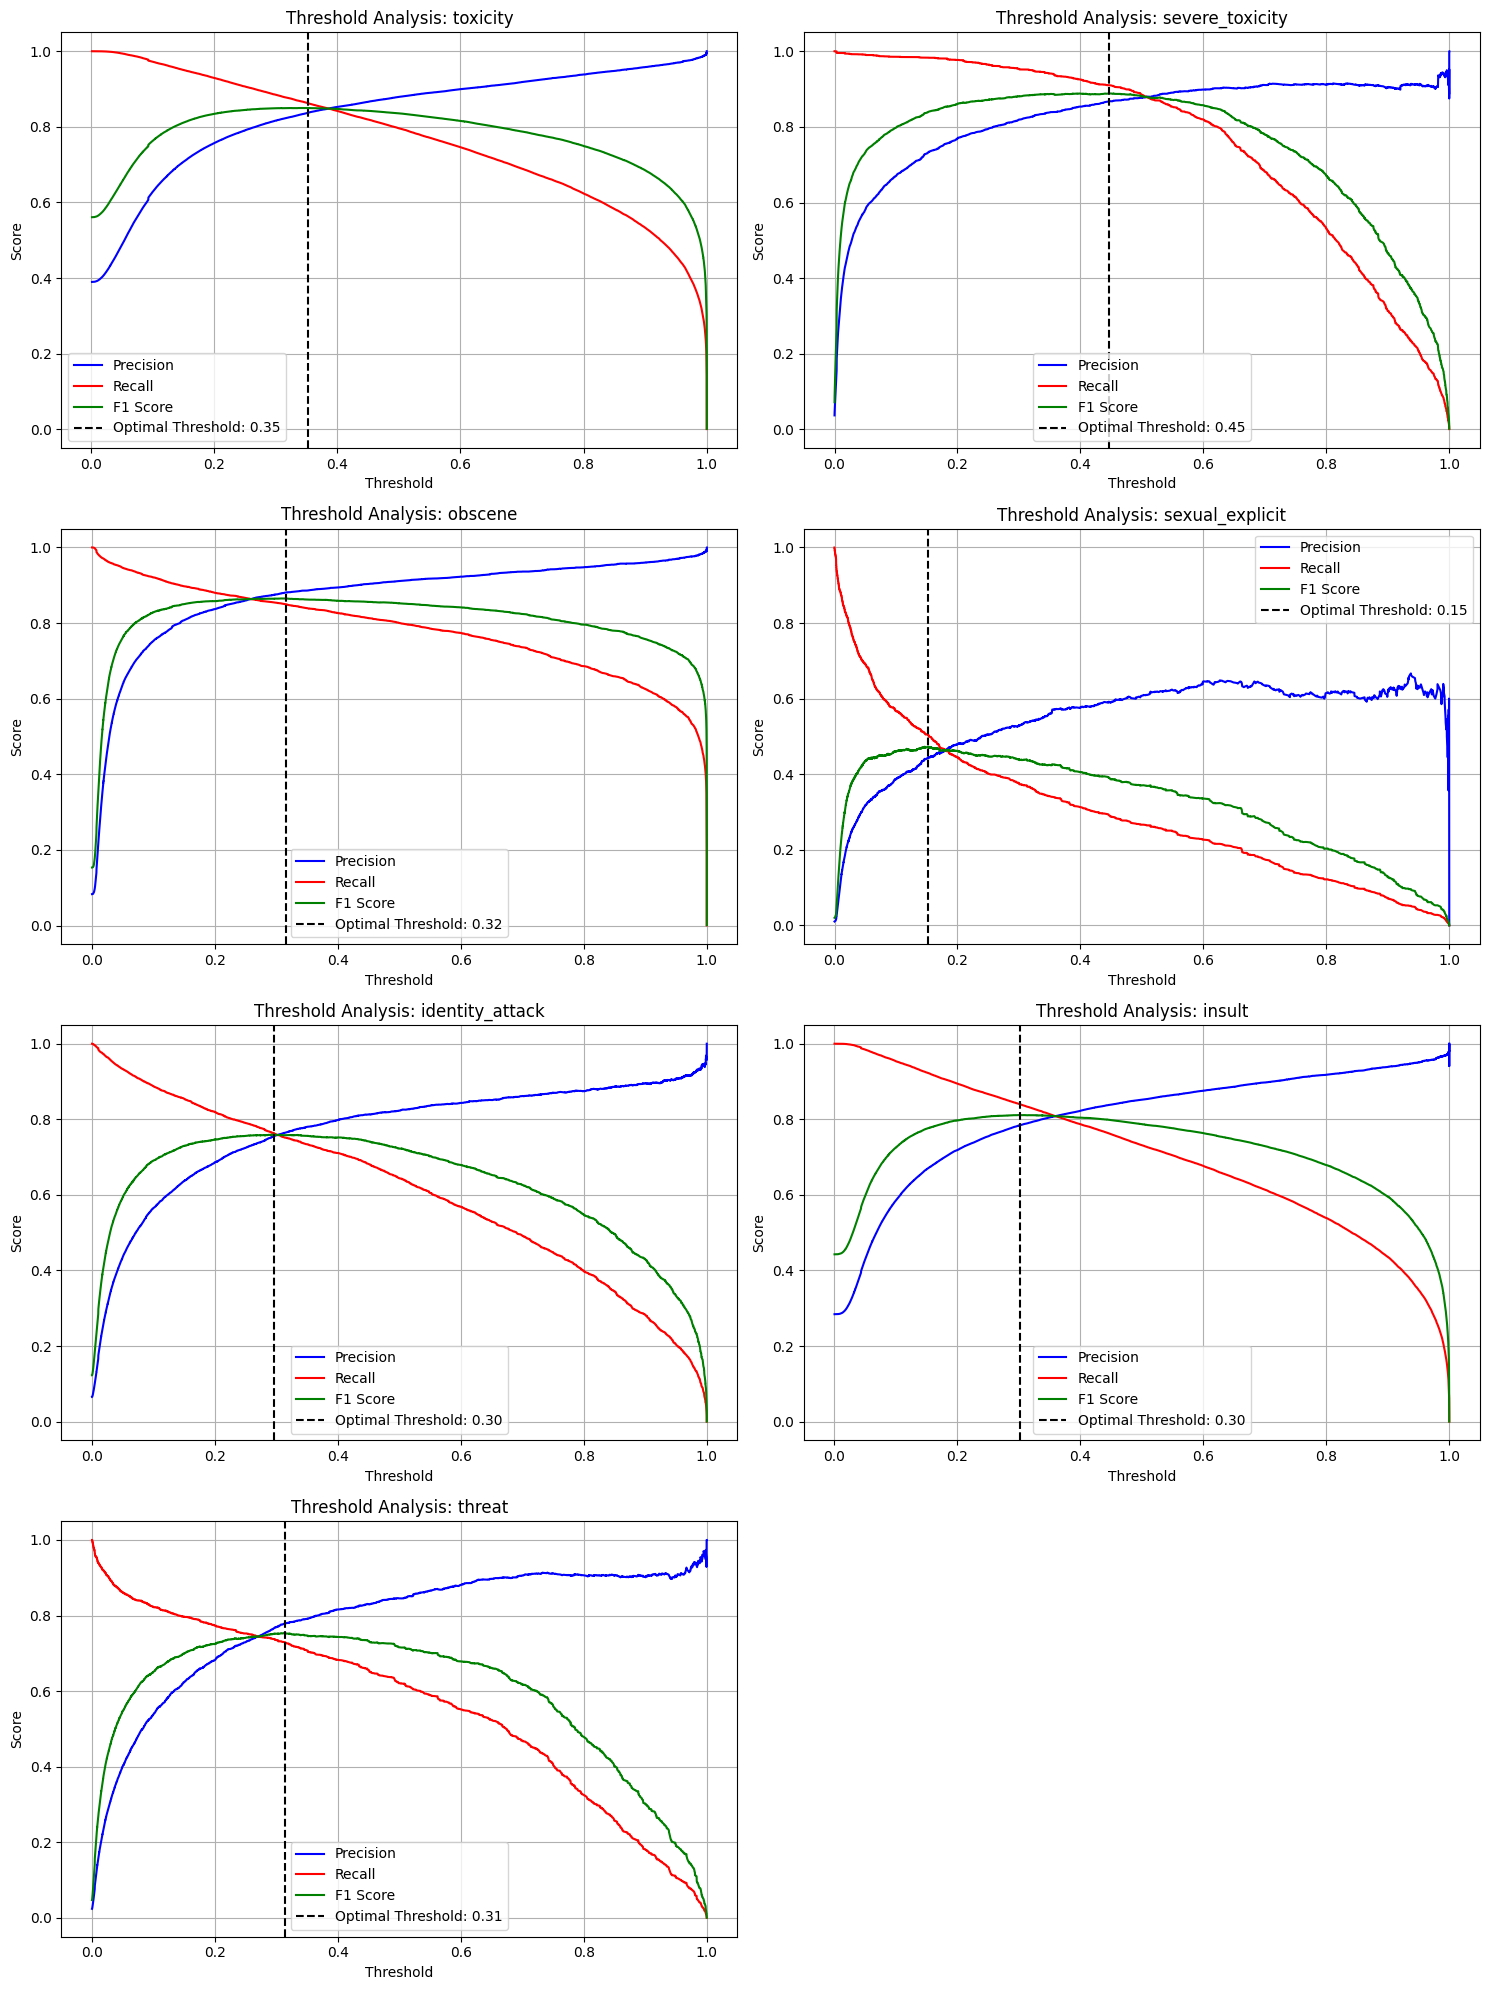


Optimal Thresholds and Metrics:
--------------------------------------------------------------------------------
Category             Threshold  Precision  Recall     F1 Score  
--------------------------------------------------------------------------------


ValueError: Invalid format specifier '.3f:<10' for object of type 'float'

In [ ]:
optimal_thresholds, optimal_metrics = perform_threshold_analysis(
    classifier=multilabel_classifier,
    X_test=X_test_tfidf,
    y_test=y_test_binary,
    toxic_categories=toxic_categories
)

# Comparing OneVSRest with Classifier Chain

In [ ]:
# Prepare the test set
y_test_binary = (y_test >= 0.5).astype(int)  # Convert to binary
test_set = (X_test_tfidf, y_test_binary)

# Convert training labels to binary
y_train_binary = (y_train >= 0.5).astype(int)  # Convert to binary

# Create the model with best parameters
model = LogisticRegression(
    C=1.0,
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    class_weight=None,
    random_state=42
)

ovr = OneVsRestClassifier(model)
ovr.fit(X_train_tfidf, y_train_binary)
Y_pred_ovr = ovr.predict(X_test_tfidf)
ovr_jaccard_score = jaccard_score(y_test_binary, Y_pred_ovr, average="samples")

chains = [ClassifierChain(model, order="random", random_state=i) for i in range(10)]
for chain in chains:
    chain.fit(X_train_tfidf, y_train_binary)

Y_pred_chains = np.array([chain.predict_proba(X_test_tfidf) for chain in chains])
chain_jaccard_scores = [
    jaccard_score(y_test_binary, Y_pred_chain >= 0.5, average="samples")
    for Y_pred_chain in Y_pred_chains
]

Y_pred_ensemble = Y_pred_chains.mean(axis=0)
ensemble_jaccard_score = jaccard_score(
    y_test_binary, Y_pred_ensemble >= 0.5, average="samples"
)

/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_div

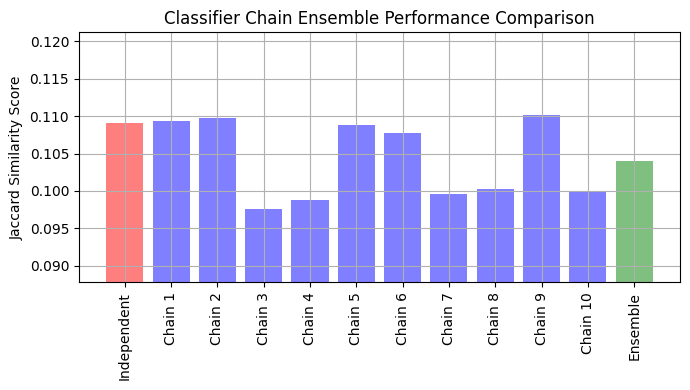

In [25]:
model_scores = [ovr_jaccard_score] + chain_jaccard_scores + [ensemble_jaccard_score]

model_names = (
    "Independent",
    "Chain 1",
    "Chain 2",
    "Chain 3",
    "Chain 4",
    "Chain 5",
    "Chain 6",
    "Chain 7",
    "Chain 8",
    "Chain 9",
    "Chain 10",
    "Ensemble",
)

x_pos = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_title("Classifier Chain Ensemble Performance Comparison")
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation="vertical")
ax.set_ylabel("Jaccard Similarity Score")
ax.set_ylim([min(model_scores) * 0.9, max(model_scores) * 1.1])
colors = ["r"] + ["b"] * len(chain_jaccard_scores) + ["g"]
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()